# Final Project -  Matthew Fehr and Jeffrey Hua

link to dataset: https://www.kaggle.com/datasets/deepcontractor/smoke-detection-dataset

# Data Preprocessing

## Load dependencies and data

In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 10.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PowerTransformer, QuantileTransformer
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier

In [ ]:
#Load Data
df = pd.read_csv("smoke_detection_iot.csv")

#Drop unnamed/id and counter
df = df.drop(columns=['Unnamed: 0'])
df = df.drop(columns=['CNT'])

df.head(100)

,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,Fire Alarm
0,1654733331,20.000,57.36,0,400,12306,18520,939.735,0.00,0.00,0.00,0.000,0.000,0
1,1654733332,20.015,56.67,0,400,12345,18651,939.744,0.00,0.00,0.00,0.000,0.000,0
2,1654733333,20.029,55.96,0,400,12374,18764,939.738,0.00,0.00,0.00,0.000,0.000,0
3,1654733334,20.044,55.28,0,400,12390,18849,939.736,0.00,0.00,0.00,0.000,0.000,0
4,1654733335,20.059,54.69,0,400,12403,18921,939.744,0.00,0.00,0.00,0.000,0.000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1654733426,21.323,53.65,23,419,12528,19619,939.799,0.22,0.69,0.39,0.788,0.449,0
96,1654733427,21.336,53.96,33,421,12524,19614,939.801,0.20,0.63,0.36,0.718,0.409,0
97,1654733428,21.349,54.25,21,417,12530,19610,939.795,0.16,0.49,0.28,0.561,0.320,0
98,1654733429,21.362,54.52,19,418,12529,19626,939.799,0.14,0.44,0.25,0.501,0.286,0


## EDA

### Shape, Missing Values and Duplicated Rows

In [ ]:
# Initial exploration

# Check the dimensions (rows, columns)
print(f"Shape of dataset: {df.shape}")

# Check column names and data types
print(f"Column Names: {df.columns}")
print(f"Data Types: {df.dtypes}")

# Check for missing values
print(f"Missing values:\n{df.isnull().sum()}")

# Check for duplicated rows
print(f"Number of duplicated rows: {df.duplicated().sum()}")

Shape of dataset: (62630, 14)
Column Names: Index(['UTC', 'Temperature[C]', 'Humidity[%]', 'TVOC[ppb]', 'eCO2[ppm]',
       'Raw H2', 'Raw Ethanol', 'Pressure[hPa]', 'PM1.0', 'PM2.5', 'NC0.5',
       'NC1.0', 'NC2.5', 'Fire Alarm'],
      dtype='object')
Data Types: UTC                 int64
Temperature[C]    float64
Humidity[%]       float64
TVOC[ppb]           int64
eCO2[ppm]           int64
Raw H2              int64
Raw Ethanol         int64
Pressure[hPa]     float64
PM1.0             float64
PM2.5             float64
NC0.5             float64
NC1.0             float64
NC2.5             float64
Fire Alarm          int64
dtype: object
Missing values:
UTC               0
Temperature[C]    0
Humidity[%]       0
TVOC[ppb]         0
eCO2[ppm]         0
Raw H2            0
Raw Ethanol       0
Pressure[hPa]     0
PM1.0             0
PM2.5             0
NC0.5             0
NC1.0             0
NC2.5             0
Fire Alarm        0
dtype: int64
Number of duplicated rows: 0


62,000 samples, 14 features and no duplicated rows

In [ ]:
#Statistical Summary

# Get descriptive statistics
df.describe()

,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,Fire Alarm
count,6.263000e+04,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000
mean,1.654792e+09,15.970424,48.539499,1942.057528,670.021044,12942.453936,19754.257912,938.627649,100.594309,184.467770,491.463608,203.586487,80.049042,0.714626
std,1.100025e+05,14.359576,8.865367,7811.589055,1905.885439,272.464305,609.513156,1.331344,922.524245,1976.305615,4265.661251,2214.738556,1083.383189,0.451596
min,1.654712e+09,-22.010000,10.740000,0.000000,400.000000,10668.000000,15317.000000,930.852000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.654743e+09,10.994250,47.530000,130.000000,400.000000,12830.000000,19435.000000,938.700000,1.280000,1.340000,8.820000,1.384000,0.033000,0.000000
50%,1.654762e+09,20.130000,50.150000,981.000000,400.000000,12924.000000,19501.000000,938.816000,1.810000,1.880000,12.450000,1.943000,0.044000,1.000000
75%,1.654778e+09,25.409500,53.240000,1189.000000,438.000000,13109.000000,20078.000000,939.418000,2.090000,2.180000,14.420000,2.249000,0.051000,1.000000
max,1.655130e+09,59.930000,75.200000,60000.000000,60000.000000,13803.000000,21410.000000,939.861000,14333.690000,45432.260000,61482.030000,51914.680000,30026.438000,1.000000


### Observe Class Distribution

Class Distribution:
Fire Alarm
1    0.714626
0    0.285374
Name: proportion, dtype: float64


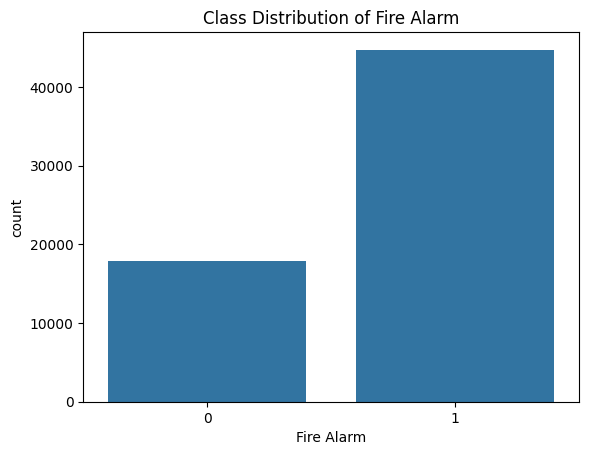

In [ ]:
#Class distribution

# Class distribution for the target variable
print(f"Class Distribution:\n{df['Fire Alarm'].value_counts(normalize=True)}")

# Plot the class distribution
sns.countplot(x='Fire Alarm', data=df)
plt.title("Class Distribution of Fire Alarm")
plt.show()

We can see that the class distribution is unbalanced. 71% of the samples are class 1 while the reamaning 29% is class 0

### Correlation Matrix for Features

                     UTC  Temperature[C]  Humidity[%]  TVOC[ppb]  eCO2[ppm]  \
UTC             1.000000       -0.164174    -0.391907   0.180731   0.132100   
Temperature[C] -0.164174        1.000000    -0.243986   0.082442   0.079265   
Humidity[%]    -0.391907       -0.243986     1.000000  -0.488878  -0.369095   
TVOC[ppb]       0.180731        0.082442    -0.488878   1.000000   0.606118   
eCO2[ppm]       0.132100        0.079265    -0.369095   0.606118   1.000000   
Raw H2         -0.151088       -0.135540     0.247199  -0.653053  -0.682785   
Raw Ethanol     0.166555       -0.037343     0.068782  -0.673715  -0.506695   
Pressure[hPa]  -0.434375       -0.251203     0.694614  -0.220004  -0.326043   
PM1.0           0.123168        0.037330    -0.236538   0.597366   0.665482   
PM2.5           0.105304        0.032084    -0.178882   0.477424   0.572691   
NC0.5           0.130288        0.039291    -0.277389   0.670657   0.699604   
NC1.0           0.103695        0.031608    -0.17422

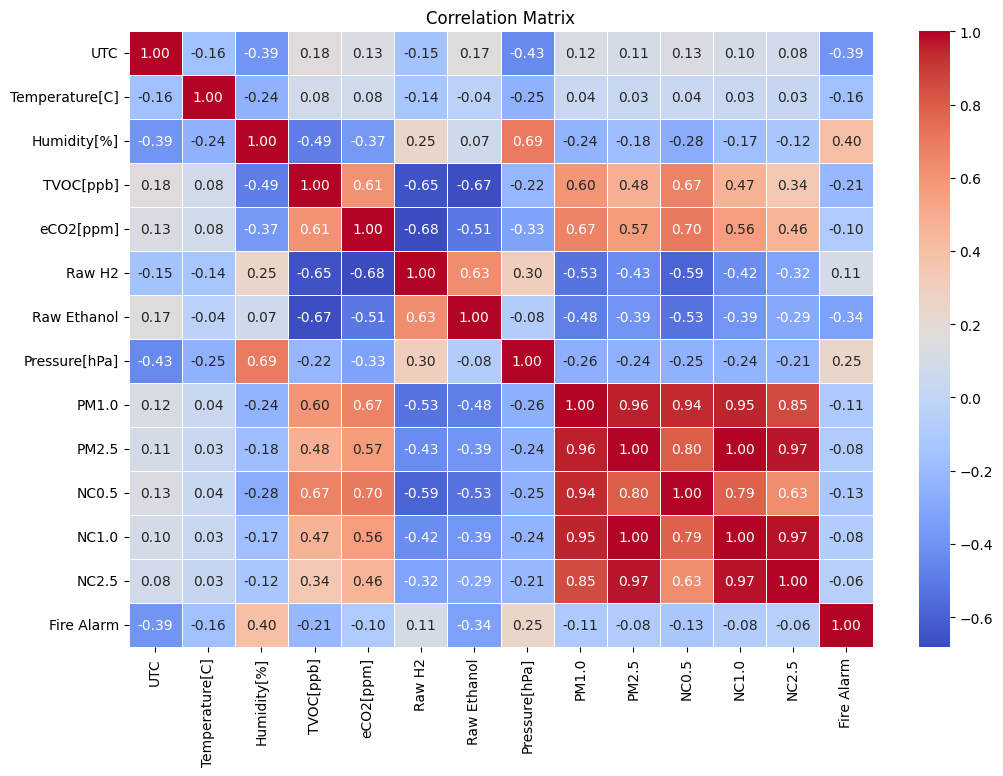

In [ ]:
# Correlation matrix
correlation_matrix = df.corr()
print(correlation_matrix)

# Heatmap for correlations
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

We can see there is high correlation (>=0.85) for a few features. Namely, PM1.0, PM2.5, NC0.5, NC1.0 and NC2.5 TVOC, eCO2, H2 and ehtnaol are also correlated with those but do not reach that 0.85 threshold.

### Feature Distribution

Skewness of numerical features:
UTC                2.546510
Temperature[C]    -0.619907
Humidity[%]       -2.460755
TVOC[ppb]          6.776903
eCO2[ppm]         12.459812
Raw H2            -2.910064
Raw Ethanol       -1.684619
Pressure[hPa]     -3.603997
PM1.0             10.752666
PM2.5             14.146225
NC0.5             10.041323
NC1.0             14.447496
NC2.5             17.736729
dtype: float64


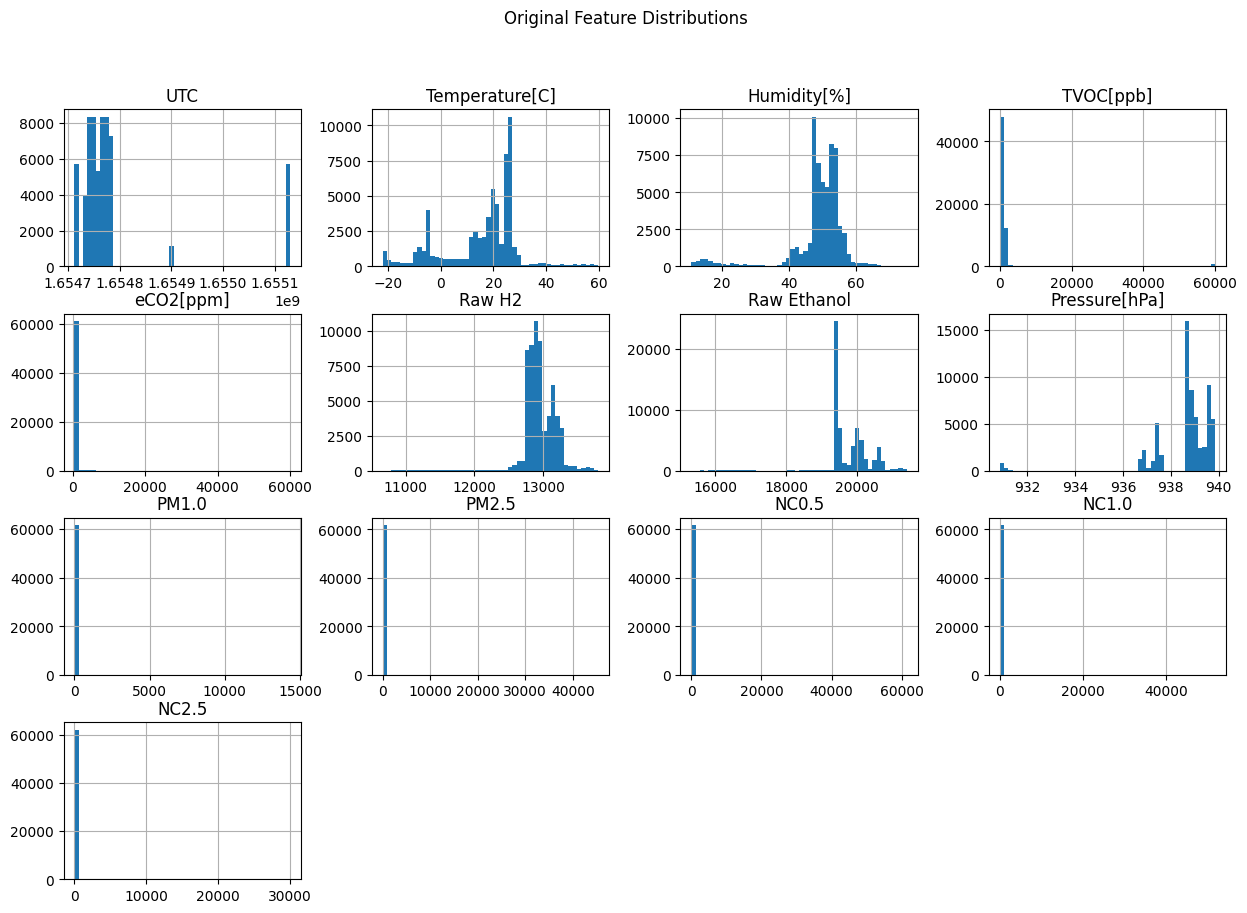

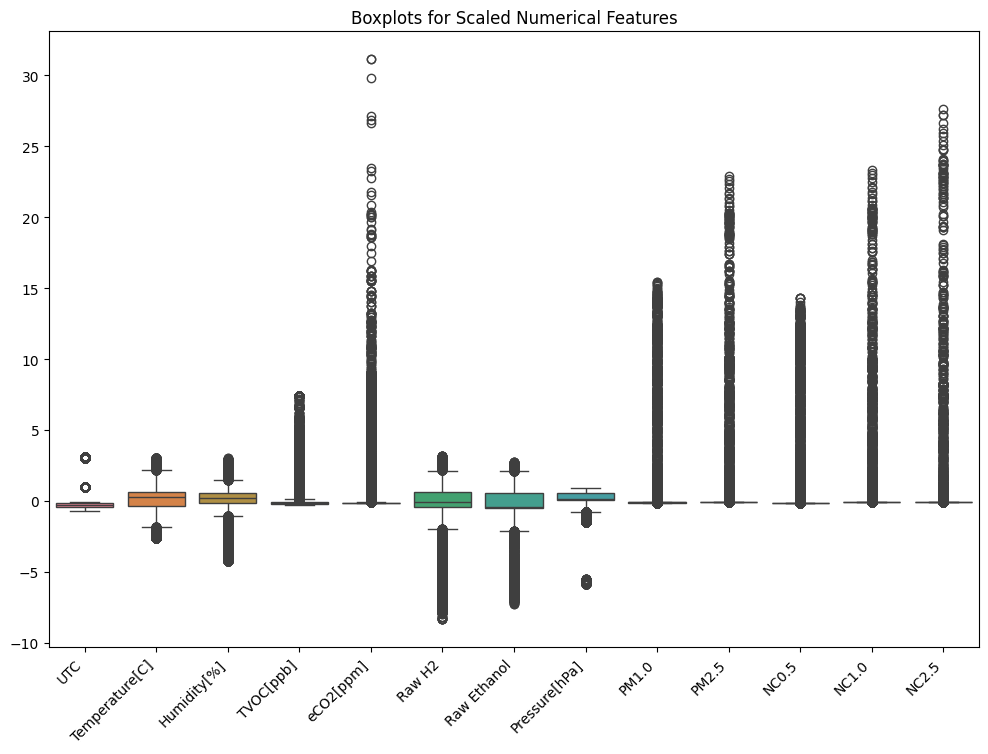

In [ ]:
# Feature distribution for skewness, outliers, or patterns

# Separate numeric features (excluding the target)
numeric_features = df.select_dtypes(include=['float64', 'int64']).drop(columns=['Fire Alarm'])

# Compute skewness on original (unscaled) numeric features
skewness = numeric_features.skew()
print("Skewness of numerical features:")
print(skewness)

# Plot histograms using original data
numeric_features.hist(figsize=(15, 10), bins=50)
plt.suptitle("Original Feature Distributions")
plt.show()

# Scale numeric features for clearer boxplot visualization
scaler = StandardScaler()
scaled_features = scaler.fit_transform(numeric_features)
scaled_df = pd.DataFrame(scaled_features, columns=numeric_features.columns)

plt.figure(figsize=(12, 8))
sns.boxplot(data=scaled_df)
plt.title("Boxplots for Scaled Numerical Features")
plt.xticks(rotation=45, ha="right")
plt.show()


Nearly all of the features have high skewness (>1 or <-1) except for temerature. This can cause bias in the models

### Time-based Analysis of Data

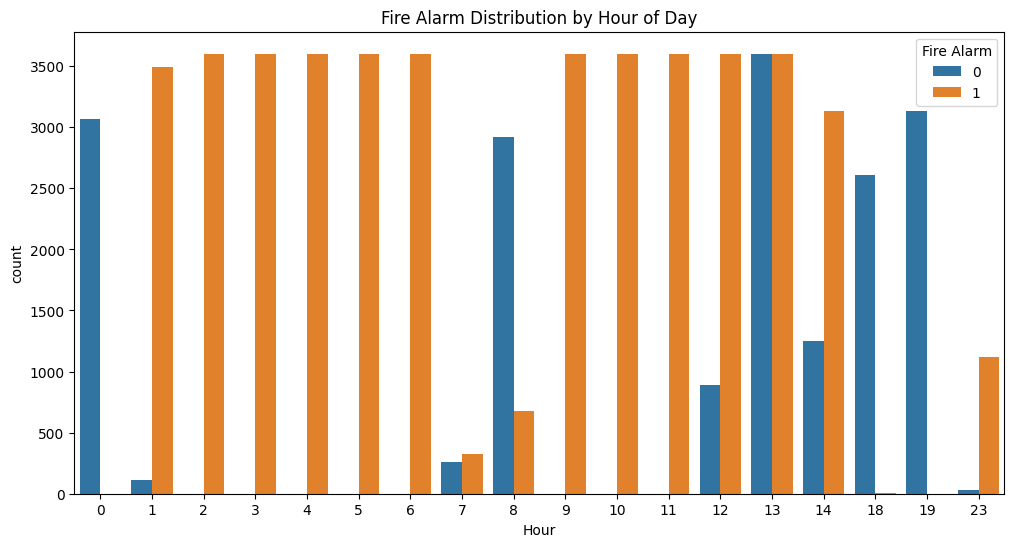

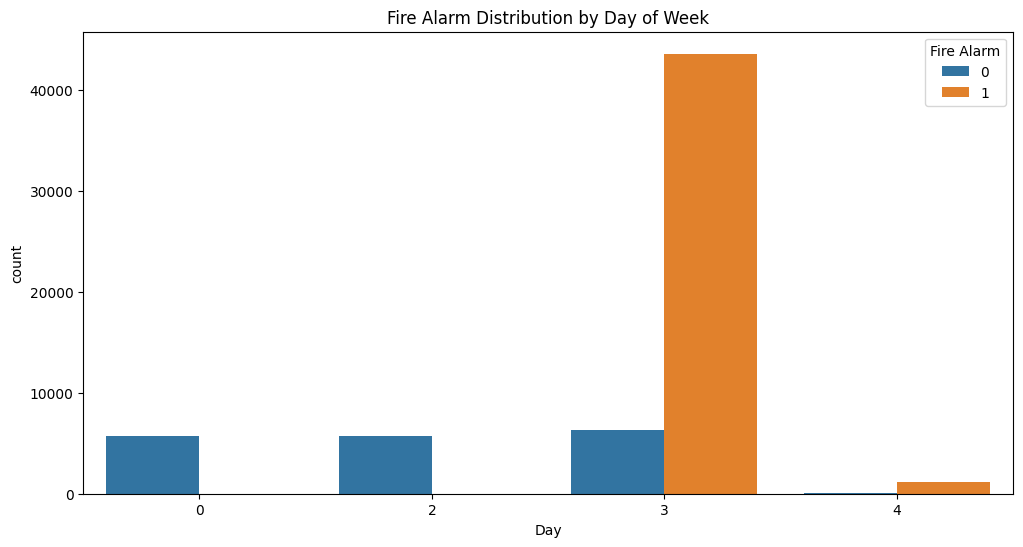

      No Fire Alarm  Fire Alarm
Hour                           
0              3069           0
1               109        3491
2                 0        3600
3                 0        3600
4                 0        3600
5                 0        3600
6                 0        3600
7               257         325
8              2921         679
9                 0        3600
10                0        3600
11                0        3600
12              890        3602
13             3600        3600
14             1252        3137
18             2611           2
19             3131           0
23               33        1121
     No Fire Alarm  Fire Alarm
Day                           
0             5742           2
2             5742           2
3             6356       43632
4               33        1121


In [ ]:
# Time based analysis

# Convert UTC timestamp to datetime
df['UTC'] = pd.to_datetime(df['UTC'], unit='s')

# Extract hour and day from the timestamp
df['Hour'] = df['UTC'].dt.hour
df['Day'] = df['UTC'].dt.dayofweek

# Plot the target variable distribution by hour and day
plt.figure(figsize=(12, 6))
sns.countplot(x='Hour', hue='Fire Alarm', data=df)
plt.title("Fire Alarm Distribution by Hour of Day")
plt.show()

plt.figure(figsize=(12, 6))
sns.countplot(x='Day', hue='Fire Alarm', data=df)
plt.title("Fire Alarm Distribution by Day of Week")
plt.show()

# Crosstab of Hour vs Fire Alarm
hourly_counts = pd.crosstab(df['Hour'], df['Fire Alarm'])
hourly_counts.columns = ['No Fire Alarm', 'Fire Alarm']
print(hourly_counts)

# Crosstab of Day vs Fire Alarm (0=Monday, 6=Sunday)
daily_counts = pd.crosstab(df['Day'], df['Fire Alarm'])
daily_counts.columns = ['No Fire Alarm', 'Fire Alarm']
print(daily_counts)


In [ ]:
#Shows these readings are seconds apart
df.head()

,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,Fire Alarm,Hour,Day
0,2022-06-09 00:08:51,20.000,57.36,0,400,12306,18520,939.735,0.0,0.0,0.0,0.0,0.0,0,0,3
1,2022-06-09 00:08:52,20.015,56.67,0,400,12345,18651,939.744,0.0,0.0,0.0,0.0,0.0,0,0,3
2,2022-06-09 00:08:53,20.029,55.96,0,400,12374,18764,939.738,0.0,0.0,0.0,0.0,0.0,0,0,3
3,2022-06-09 00:08:54,20.044,55.28,0,400,12390,18849,939.736,0.0,0.0,0.0,0.0,0.0,0,0,3
4,2022-06-09 00:08:55,20.059,54.69,0,400,12403,18921,939.744,0.0,0.0,0.0,0.0,0.0,0,0,3


All of the readings are only 1 second apart, the readings only cover a span of 4 days, and samples of the same class are grouped together in the same time frame. All these things make any sort of time prediction difficult since using time would likely only bias the model

### Find Outliers

In [ ]:
# Find outliers

# Calculate Z-scores for all numerical features
z_scores = stats.zscore(df.select_dtypes(include=['float64', 'int64']))

# Identify outliers (Z-score > 3 or < -3)
outliers = (abs(z_scores) > 3).all(axis=1)

# Total number of outliers
num_outliers = outliers.sum()
print(f"Number of detected outliers: {num_outliers}")

# Check if there are any outliers
if num_outliers > 0:
    print("Outliers detected.")
else:
    print("No outliers detected.")

Number of detected outliers: 0
No outliers detected.


z-score was used to find whether there are outliers. Anything with a |z-score| > 3 was deemed an outlier but there were none.

# Initial Model Designs

## Baselines Models with Unbalanced Data

In [ ]:
# Normalize Values and create test and training sets

# Drop Features and Target
X = df.drop(['Fire Alarm', 'UTC', 'Hour', 'Day'], axis=1)  # Remove time stuff and target
y = df['Fire Alarm']

# Split the data into training and set with a 80-20 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

The data was split and scaled. Only the training set was used to fit the the scaler so only training data is used for scaling. This prevents leakage.

### Logisitc Regression, Decision Tree, SVM, Naive Bayes

Evaluation for Logistic Regression:
Training Accuracy: 0.8970
Testing Accuracy: 0.8956
              precision    recall  f1-score   support

           0       0.86      0.76      0.81      3594
           1       0.91      0.95      0.93      8932

    accuracy                           0.90     12526
   macro avg       0.88      0.86      0.87     12526
weighted avg       0.89      0.90      0.89     12526

[[2733  861]
 [ 447 8485]]


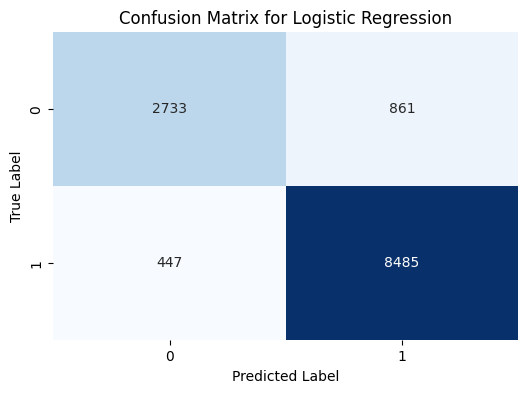

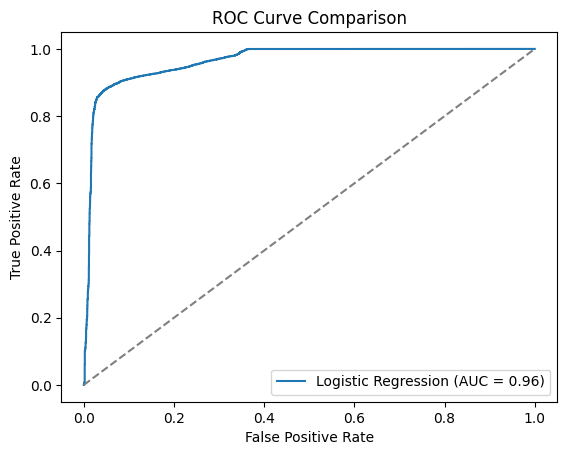

---------------------------------------------------------------------------
Evaluation for Decision Tree:
Training Accuracy: 1.0000
Testing Accuracy: 0.9998
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3594
           1       1.00      1.00      1.00      8932

    accuracy                           1.00     12526
   macro avg       1.00      1.00      1.00     12526
weighted avg       1.00      1.00      1.00     12526

[[3593    1]
 [   1 8931]]


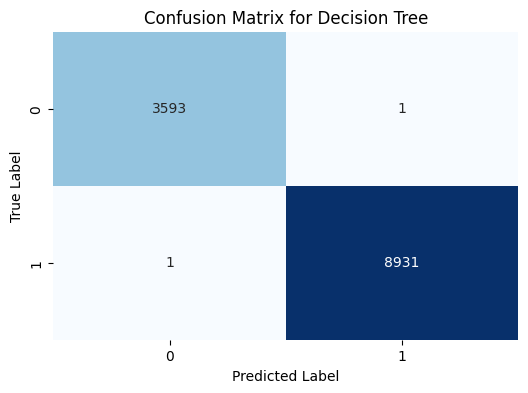

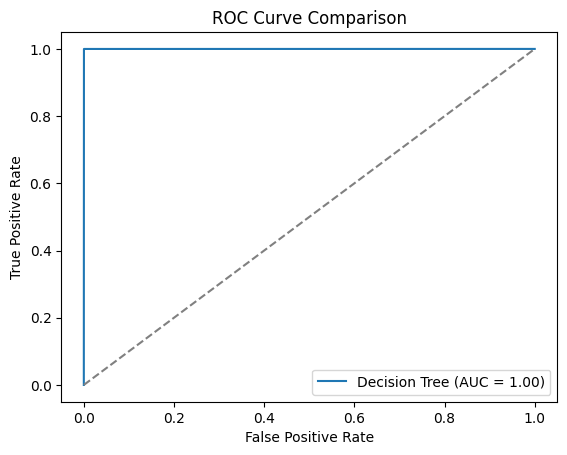

---------------------------------------------------------------------------
Evaluation for SVM:
Training Accuracy: 0.9678
Testing Accuracy: 0.9685
              precision    recall  f1-score   support

           0       0.98      0.91      0.94      3594
           1       0.97      0.99      0.98      8932

    accuracy                           0.97     12526
   macro avg       0.97      0.95      0.96     12526
weighted avg       0.97      0.97      0.97     12526

[[3281  313]
 [  81 8851]]


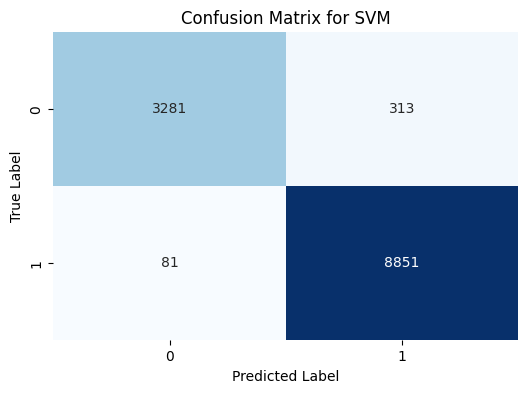

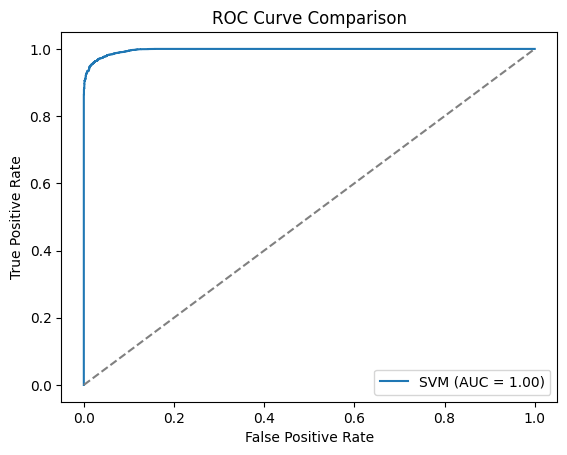

---------------------------------------------------------------------------
Evaluation for Naive Bayes:
Training Accuracy: 0.7657
Testing Accuracy: 0.7637
              precision    recall  f1-score   support

           0       0.79      0.24      0.37      3594
           1       0.76      0.97      0.85      8932

    accuracy                           0.76     12526
   macro avg       0.77      0.61      0.61     12526
weighted avg       0.77      0.76      0.72     12526

[[ 870 2724]
 [ 236 8696]]


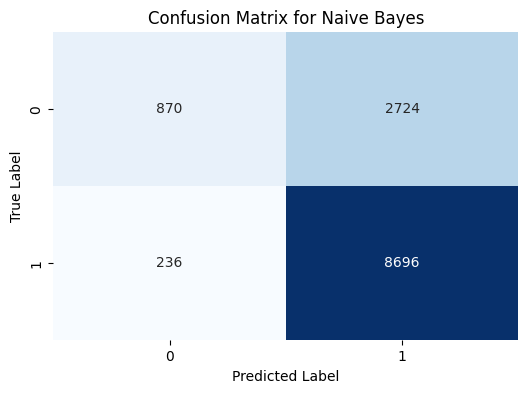

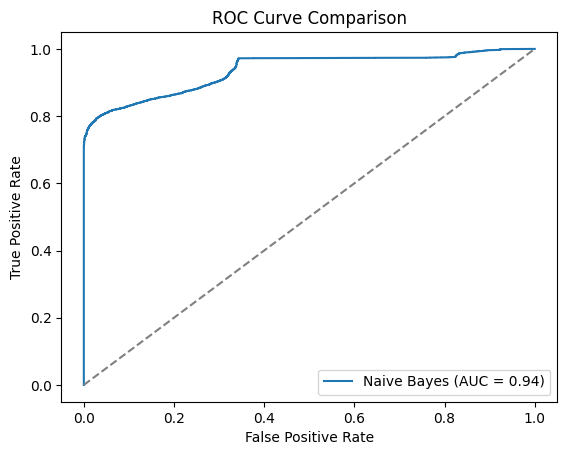

---------------------------------------------------------------------------


In [ ]:
#Baselines models with basic dataset

# Define models
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'SVM': SVC(probability=True),
    'Naive Bayes': GaussianNB()
}

# Train and evaluate each model
for name, model in models.items():
    #Train the model
    model.fit(X_train_scaled, y_train)

    # Make predictions on training data
    y_train_pred = model.predict(X_train_scaled)

    # Make predictions on testing data
    y_test_pred = model.predict(X_test_scaled)

    # Calculate training and testing accuracy
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    print(f"Evaluation for {name}:")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Testing Accuracy: {test_accuracy:.4f}")
    print(classification_report(y_test, y_test_pred))
    print(confusion_matrix(y_test, y_test_pred))

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Compute ROC curve
    y_proba = model.predict_proba(X_test_scaled)[:, 1]  #this gets the probability estimates from prediction which is needed for ROC that uses probabilities
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Diagonal line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve Comparison")       #print ROC curve to get a visualization of AUC and performance
    plt.legend()
    plt.show()

    print("-" * 75)



SVM and Decision Tree are already extrememly good. Logistic Regression is also pretty good at 90% with Bayes being the only lackluster one at 76%. This makes sense as Bayes assumes independence among features, which is not the case here.

### MLP

In [ ]:
# Try deep learning model (using non-resampled data)

# Define the MLP model
mlp = Sequential()
mlp.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))  # Use scaled original data
mlp.add(Dropout(0.3))
mlp.add(Dense(32, activation='relu'))
mlp.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile the model
mlp.compile(optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy'])

# Train the model on original, non-resampled data
history = mlp.fit(X_train_scaled, y_train,
                  validation_split=0.2,
                  epochs=10,
                  batch_size=32,
                  verbose=1)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1253/1253 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8784 - loss: 0.2784 - val_accuracy: 0.9652 - val_loss: 0.0846
Epoch 2/10
1253/1253 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9638 - loss: 0.0880 - val_accuracy: 0.9831 - val_loss: 0.0542
Epoch 3/10
1253/1253 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9769 - loss: 0.0611 - val_accuracy: 0.9902 - val_loss: 0.0389
Epoch 4/10
1253/1253 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9830 - loss: 0.0478 - val_accuracy: 0.9915 - val_loss: 0.0300
Epoch 5/10
1253/1253 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9847 - loss: 0.0446 - val_accuracy: 0.9906 - val_loss: 0.0284
Epoch 6/10
1253/1253 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9868 - loss: 0.0369 - val_accuracy: 0.9915 - val_loss: 0.0258
Epoch 7/10
1253/1253 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9883 - loss: 0.0329 - val_accuracy: 0.9934 - val_loss: 0.0227
Epoch 8/10
1253/1253 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9895 - loss: 0.0298 - val_accurac

1566/1566 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Evaluation for MLP (non-SMOTE):
Training Accuracy: 0.9944
Testing Accuracy: 0.9952
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      3594
           1       0.99      1.00      1.00      8932

    accuracy                           1.00     12526
   macro avg       1.00      0.99      0.99     12526
weighted avg       1.00      1.00      1.00     12526

[[3536   58]
 [   2 8930]]


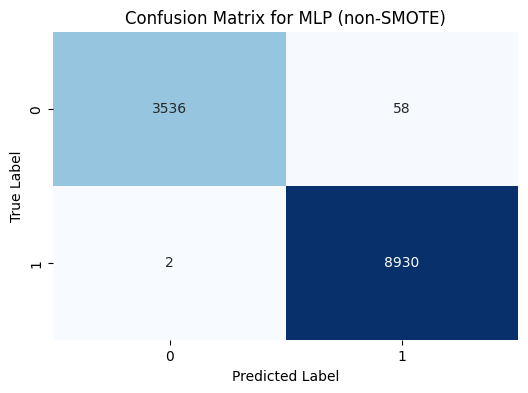

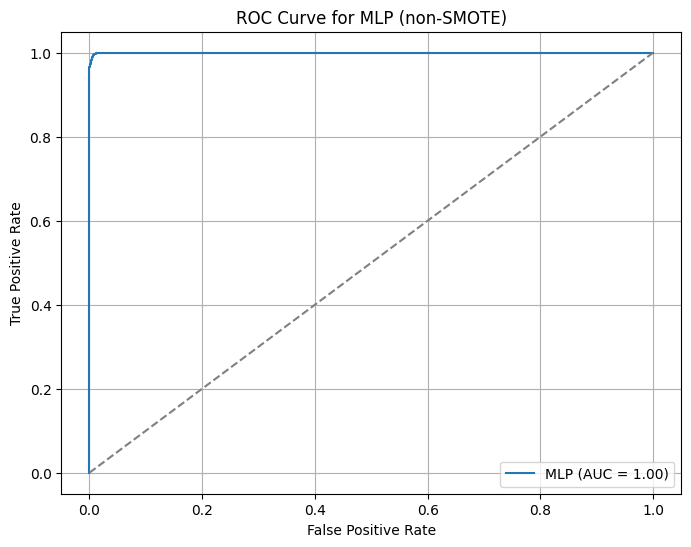

In [ ]:
# Predict on training and test sets
y_train_pred_prob = mlp.predict(X_train_scaled).ravel()  # Using scaled original data
y_test_pred_prob = mlp.predict(X_test_scaled).ravel()

# Binarize the predictions
y_train_pred = (y_train_pred_prob >= 0.5).astype(int)
y_test_pred = (y_test_pred_prob >= 0.5).astype(int)

# Evaluation
train_accuracy = accuracy_score(y_train, y_train_pred)  # Use original y_train
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Evaluation for MLP (non-SMOTE):")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")
print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))

# Pretty Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for MLP (non-SMOTE)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'MLP (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for MLP (non-SMOTE)')
plt.legend()
plt.grid()
plt.show()

Very good innitial results, only bad thing is 58 false positives. This could be caused by the imbalance.

### Random Forest

Evaluation for Random Forest (non-SMOTE):
Training Accuracy: 1.0000
Testing Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3594
           1       1.00      1.00      1.00      8932

    accuracy                           1.00     12526
   macro avg       1.00      1.00      1.00     12526
weighted avg       1.00      1.00      1.00     12526

[[3594    0]
 [   0 8932]]


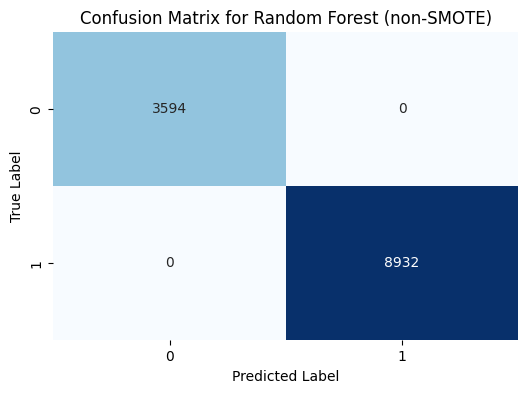

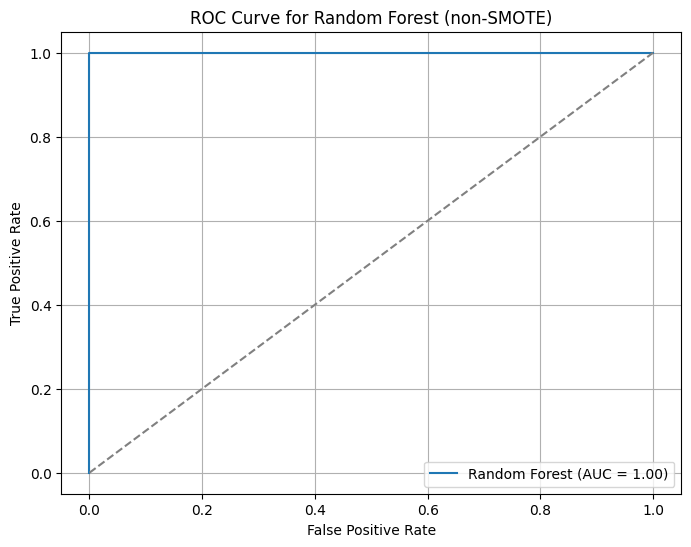

In [ ]:
# Try ensemble method (using non-resampled data)

# Initialize Random Forest
rf_model = RandomForestClassifier(n_estimators=50, random_state=42)

# Train the model on the original (non-resampled) data
rf_model.fit(X_train_scaled, y_train)

# Predict on train and test sets
y_train_pred = rf_model.predict(X_train_scaled)  # Use scaled original training data
y_test_pred = rf_model.predict(X_test_scaled)
y_test_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

# Accuracy scores
train_accuracy = accuracy_score(y_train, y_train_pred)  # Use original y_train
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print metrics
print("Evaluation for Random Forest (non-SMOTE):")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")
print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))

# Pretty Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for Random Forest (non-SMOTE)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest (non-SMOTE)')
plt.legend()
plt.grid()
plt.show()


Perfect model

# Model Improvements

## Balanced Dataset

In [ ]:
# Balance dataset

# Drop features based on correlation and low importance
features_to_drop = ['UTC', 'Hour', 'Day']
target_col = 'Fire Alarm'

# Drop selected features
X = df.drop(columns=features_to_drop + [target_col])
y = df[target_col]

# Stratified Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SMOTE-ENN for balancing
smote_enn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train_scaled, y_train)

# Class balance check
print("Before SMOTE:", y_train.value_counts(normalize=True))
print("After SMOTE:", pd.Series(y_train_resampled).value_counts(normalize=True))

Before SMOTE: Fire Alarm
1    0.714634
0    0.285366
Name: proportion, dtype: float64
After SMOTE: Fire Alarm
0    0.500217
1    0.499783
Name: proportion, dtype: float64


SMOTE-ENN and stratification used to data augment and create syntehtic samples of the minority calss

### Logistic Regression, Decision Tree, SVM, Naive Bayes

Evaluation for Logistic Regression:
Training Accuracy: 0.9095
Testing Accuracy: 0.9011
              precision    recall  f1-score   support

           0       0.77      0.92      0.84      3575
           1       0.97      0.89      0.93      8951

    accuracy                           0.90     12526
   macro avg       0.87      0.91      0.88     12526
weighted avg       0.91      0.90      0.90     12526

[[3298  277]
 [ 962 7989]]


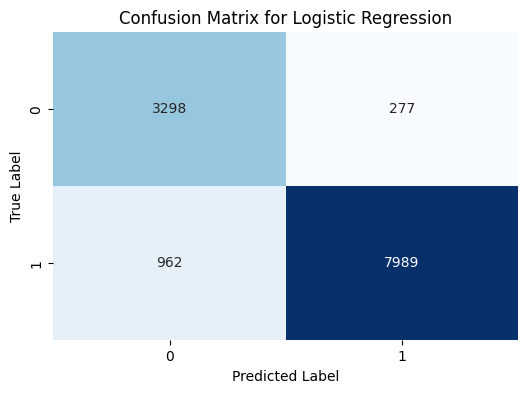

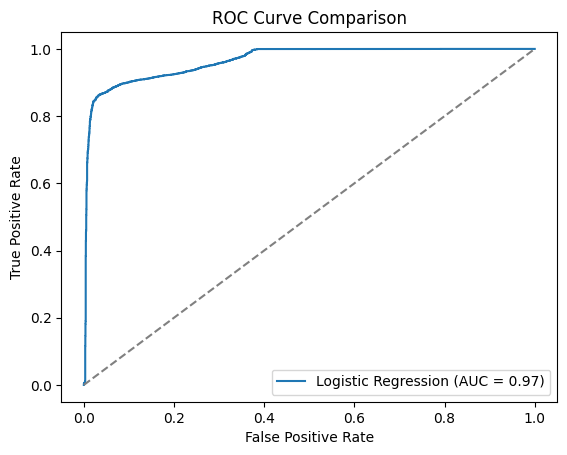

---------------------------------------------------------------------------
Evaluation for Decision Tree:
Training Accuracy: 1.0000
Testing Accuracy: 0.9996
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3575
           1       1.00      1.00      1.00      8951

    accuracy                           1.00     12526
   macro avg       1.00      1.00      1.00     12526
weighted avg       1.00      1.00      1.00     12526

[[3574    1]
 [   4 8947]]


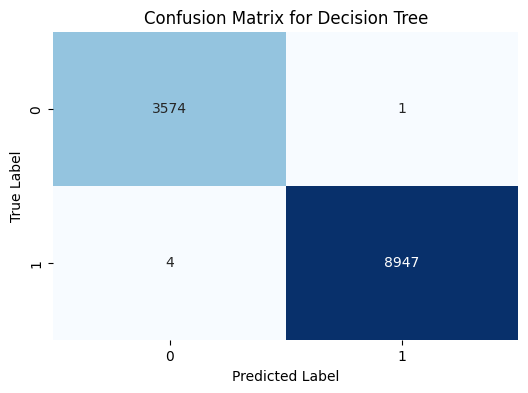

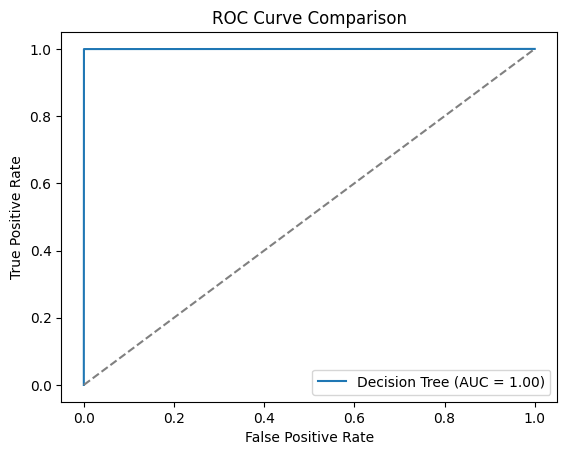

---------------------------------------------------------------------------
Evaluation for SVM:
Training Accuracy: 0.9677
Testing Accuracy: 0.9551
              precision    recall  f1-score   support

           0       0.87      0.99      0.93      3575
           1       1.00      0.94      0.97      8951

    accuracy                           0.96     12526
   macro avg       0.93      0.97      0.95     12526
weighted avg       0.96      0.96      0.96     12526

[[3548   27]
 [ 535 8416]]


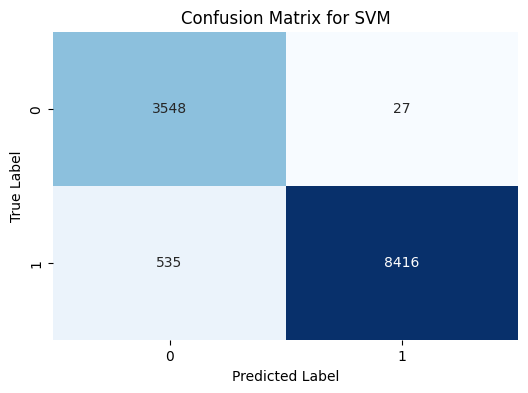

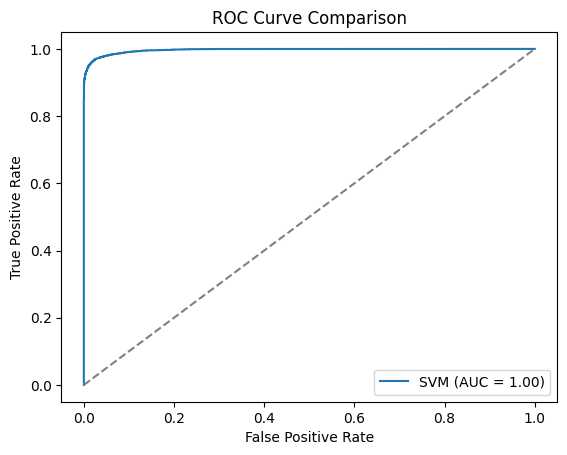

---------------------------------------------------------------------------
Evaluation for Naive Bayes:
Training Accuracy: 0.6104
Testing Accuracy: 0.7712
              precision    recall  f1-score   support

           0       0.81      0.26      0.39      3575
           1       0.77      0.97      0.86      8951

    accuracy                           0.77     12526
   macro avg       0.79      0.62      0.63     12526
weighted avg       0.78      0.77      0.73     12526

[[ 933 2642]
 [ 224 8727]]


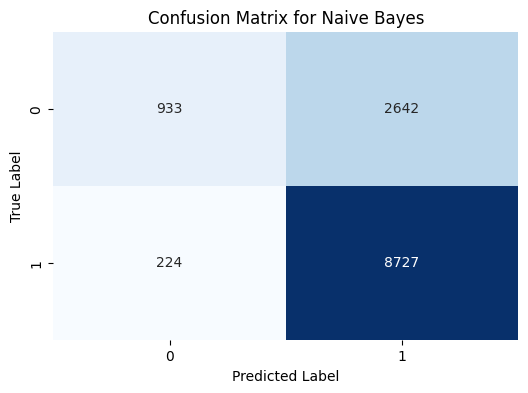

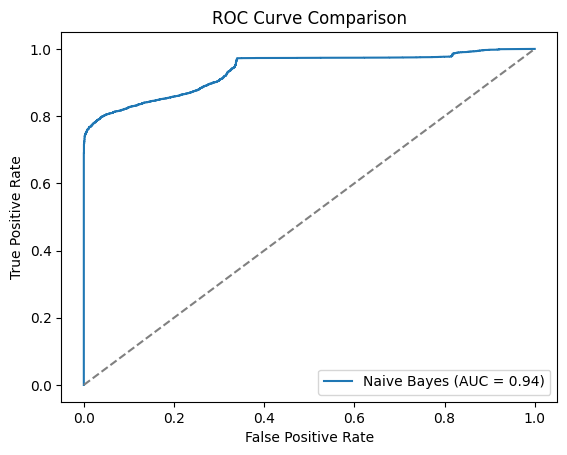

---------------------------------------------------------------------------


In [ ]:
#Create basic models and test them with balanced dataset

# Define models
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'SVM': SVC(probability=True),
    'Naive Bayes': GaussianNB()
}

# Train and evaluate each model
for name, model in models.items():
    #Train the model
    model.fit(X_train_resampled, y_train_resampled)

    # Make predictions on training data
    y_train_pred = model.predict(X_train_resampled)

    # Make predictions on testing data
    y_test_pred = model.predict(X_test_scaled)

    # Calculate training and testing accuracy
    train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    print(f"Evaluation for {name}:")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Testing Accuracy: {test_accuracy:.4f}")
    print(classification_report(y_test, y_test_pred))
    print(confusion_matrix(y_test, y_test_pred))

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Compute ROC curve
    y_proba = model.predict_proba(X_test_scaled)[:, 1]  #this gets the probability estimates from prediction which is needed for ROC that uses probabilities
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Diagonal line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve Comparison")       #print ROC curve to get a visualization of AUC and performance
    plt.legend()
    plt.show()

    print("-" * 75)


Mixed bag. Some performed slightly worse while others slightly better. But the change is so minimal it is likely luck. One weird thing though is that the training accuracy for Bayes dropped a lot, making the testing accuracy higher than the training now. This could mean underfitting.

### MLP

In [ ]:
# Try deep learning model

# Define the MLP model
mlp = Sequential()
mlp.add(Dense(64, input_dim=X_train_resampled.shape[1], activation='relu'))  # Resampled data
mlp.add(Dropout(0.3))
mlp.add(Dense(32, activation='relu'))
mlp.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile the model
mlp.compile(optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy'])

# Train the model
history = mlp.fit(X_train_resampled, y_train_resampled,
                  validation_split=0.2,
                  epochs=10,
                  batch_size=32,
                  verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1788/1788 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9047 - loss: 0.2416 - val_accuracy: 0.9185 - val_loss: 0.1412
Epoch 2/10
1788/1788 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9712 - loss: 0.0804 - val_accuracy: 0.9641 - val_loss: 0.0780
Epoch 3/10
1788/1788 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9776 - loss: 0.0615 - val_accuracy: 0.9636 - val_loss: 0.0808
Epoch 4/10
1788/1788 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9807 - loss: 0.0539 - val_accuracy: 0.9851 - val_loss: 0.0344
Epoch 5/10
1788/1788 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9855 - loss: 0.0408 - val_accuracy: 0.9862 - val_loss: 0.0314
Epoch 6/10
1788/1788 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9873 - loss: 0.0334 - val_accuracy: 0.9928 - val_loss: 0.0229
Epoch 7/10
1788/1788 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9896 - loss: 0.0294 - val_accuracy: 0.9950 - val_loss: 0.0181
Epoch 8/10
1788/1788 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9902 - loss: 0.0268 - 

2235/2235 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Evaluation for MLP:
Training Accuracy: 0.9935
Testing Accuracy: 0.9926
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3575
           1       1.00      0.99      0.99      8951

    accuracy                           0.99     12526
   macro avg       0.99      0.99      0.99     12526
weighted avg       0.99      0.99      0.99     12526

[[3558   17]
 [  76 8875]]


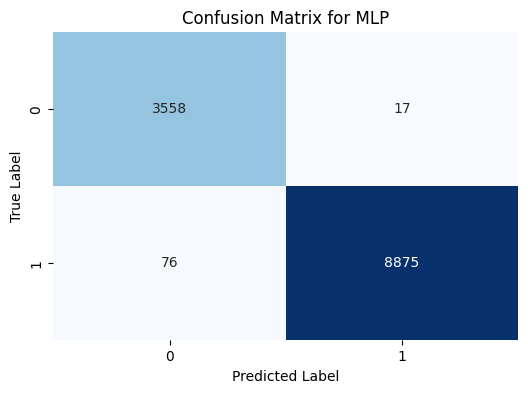

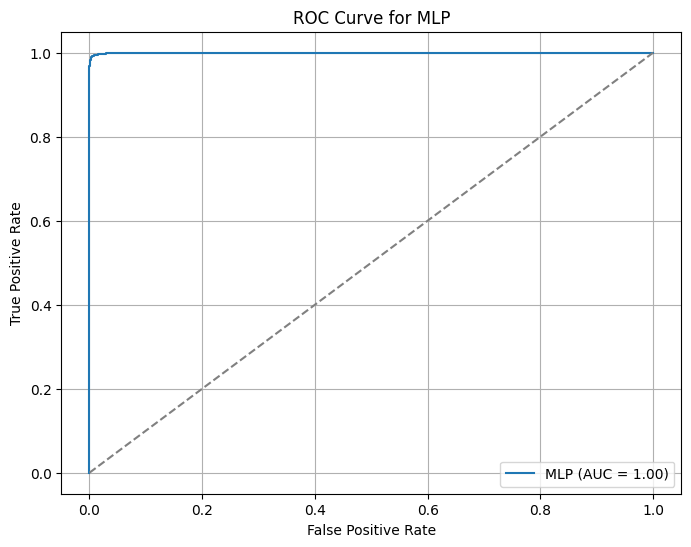

In [ ]:
# Predict on training and test sets
y_train_pred_prob = mlp.predict(X_train_resampled).ravel()
y_test_pred_prob = mlp.predict(X_test_scaled).ravel()

# Binarize the predictions
y_train_pred = (y_train_pred_prob >= 0.5).astype(int)
y_test_pred = (y_test_pred_prob >= 0.5).astype(int)

# Evaluation
train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Evaluation for MLP:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")
print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))

# Pretty Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for MLP')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'MLP (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for MLP')
plt.legend()
plt.grid()
plt.show()

There is an increase in false negatives now for MLP but the number of false positives decreased. The data augmentation may have caused misclassification of negatives now as that was the minority class

### Random Forest

Evaluation for Random Forest:
Training Accuracy: 1.0000
Testing Accuracy: 0.9999
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3575
           1       1.00      1.00      1.00      8951

    accuracy                           1.00     12526
   macro avg       1.00      1.00      1.00     12526
weighted avg       1.00      1.00      1.00     12526

[[3575    0]
 [   1 8950]]


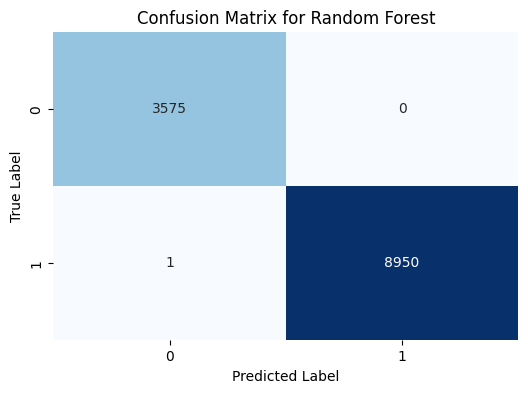

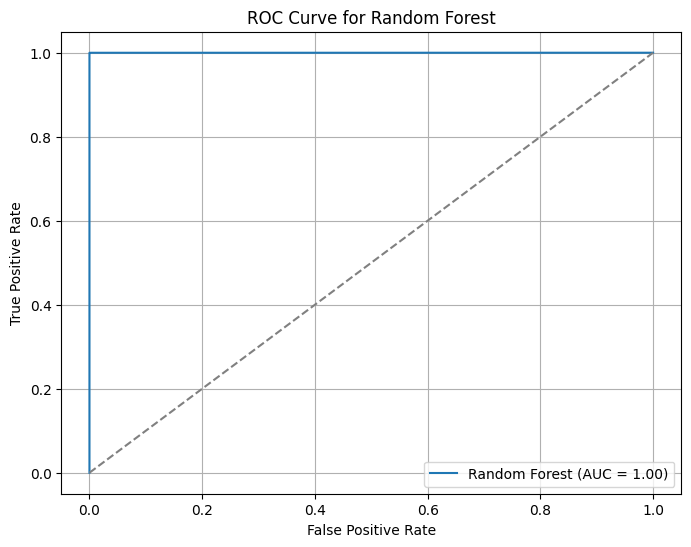

In [ ]:
# Try ensemble method

# Initialize Random Forest
rf_model = RandomForestClassifier(n_estimators=50, random_state=42)

# Train the model
rf_model.fit(X_train_resampled, y_train_resampled)

# Predict on train and test sets
y_train_pred = rf_model.predict(X_train_resampled)
y_test_pred = rf_model.predict(X_test_scaled)
y_test_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

# Accuracy scores
train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print metrics
print("Evaluation for Random Forest:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")
print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))

# Pretty Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for Random Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest')
plt.legend()
plt.grid()
plt.show()


One false negative now, could be due to poor data augmentation

## Feature Selection

Feature Importances
           Feature  Importance
2        TVOC[ppb]    0.273369
6    Pressure[hPa]    0.194175
5      Raw Ethanol    0.128631
1      Humidity[%]    0.125935
4           Raw H2    0.066506
7            PM1.0    0.058090
0   Temperature[C]    0.041036
8            PM2.5    0.037747
9            NC0.5    0.029871
11           NC2.5    0.016040
10           NC1.0    0.015779
3        eCO2[ppm]    0.012822


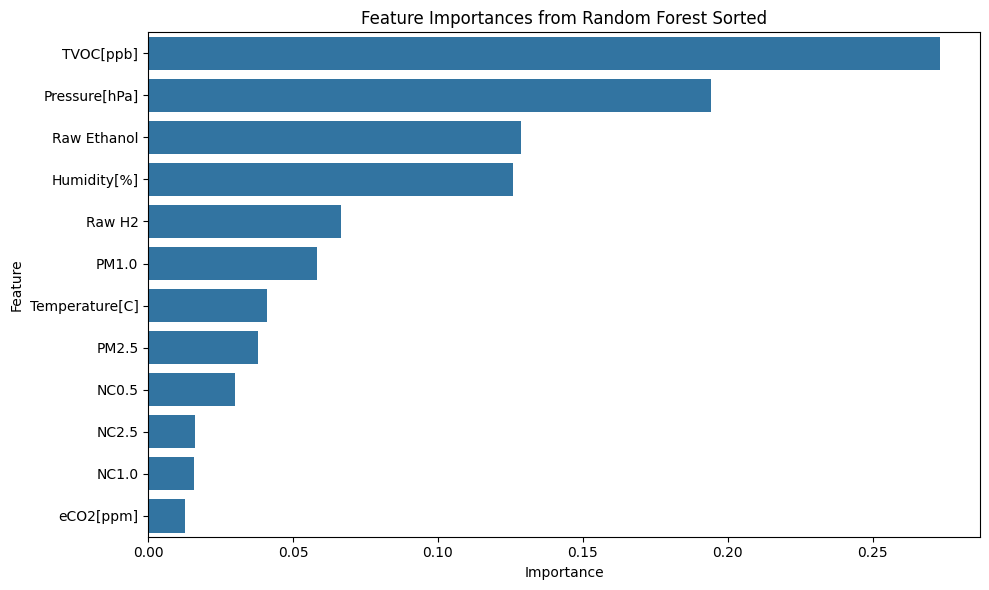

In [ ]:
# Feature importance analysis

# Use feature names from the original DataFrame X
feature_names = X.columns

# Get feature importances
importances = rf_model.feature_importances_

# Create a DataFrame for better readability and plotting
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Print top features
print("Feature Importances")
print(feature_importance_df.head(len(feature_names)))

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
plt.title('Feature Importances from Random Forest Sorted')
plt.tight_layout()
plt.show()


The random forest was used to give the importance of each feature. This shows how much each feature contributes to the classification.

In [ ]:
# Feature selection

# Drop features based on correlation and low importance
features_to_drop = ['PM2.5', 'NC0.5', 'NC1.0', 'NC2.5', 'eCO2[ppm]', 'UTC', 'Hour', 'Day']
target_col = 'Fire Alarm'

# Drop selected features
X = df.drop(columns=features_to_drop + [target_col])
y = df[target_col]

# Stratified Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SMOTE-ENN for balancing
smote_enn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train_scaled, y_train)

# Remaining features check
print("Remaining features:")
print(X.columns)


Remaining features:
Index(['Temperature[C]', 'Humidity[%]', 'TVOC[ppb]', 'Raw H2', 'Raw Ethanol',
       'Pressure[hPa]', 'PM1.0'],
      dtype='object')


The highly correlated features from earlier were dropped except PM1.0 as it had the highest importance. And eCO2 was dropped due to low importance.

### Logistic Regression, Decision Tree, SVM, Naive Bayes

Evaluation for Logistic Regression:
Training Accuracy: 0.9059
Testing Accuracy: 0.8983
              precision    recall  f1-score   support

           0       0.77      0.91      0.84      3575
           1       0.96      0.89      0.93      8951

    accuracy                           0.90     12526
   macro avg       0.87      0.90      0.88     12526
weighted avg       0.91      0.90      0.90     12526

[[3258  317]
 [ 957 7994]]


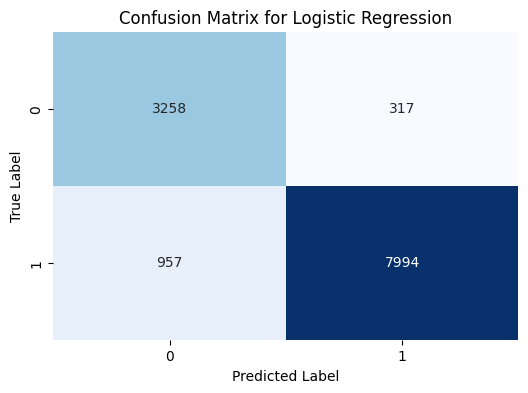

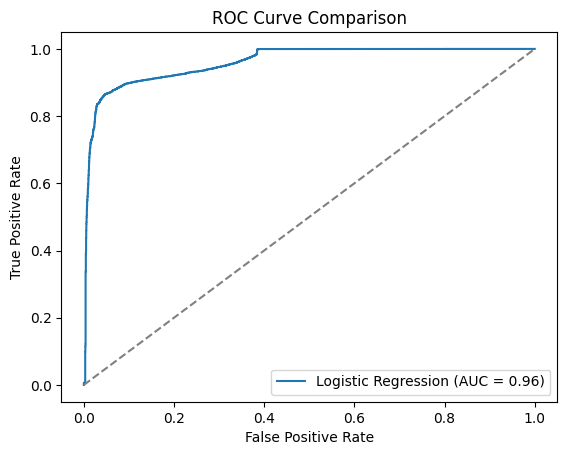

---------------------------------------------------------------------------
Evaluation for Decision Tree:
Training Accuracy: 1.0000
Testing Accuracy: 0.9996
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3575
           1       1.00      1.00      1.00      8951

    accuracy                           1.00     12526
   macro avg       1.00      1.00      1.00     12526
weighted avg       1.00      1.00      1.00     12526

[[3575    0]
 [   5 8946]]


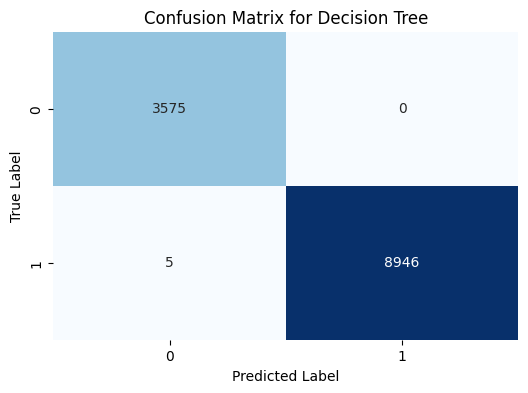

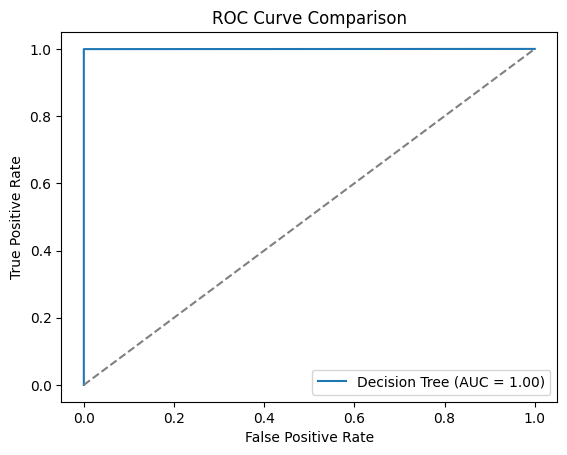

---------------------------------------------------------------------------
Evaluation for SVM:
Training Accuracy: 0.9797
Testing Accuracy: 0.9715
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      3575
           1       1.00      0.96      0.98      8951

    accuracy                           0.97     12526
   macro avg       0.96      0.98      0.97     12526
weighted avg       0.97      0.97      0.97     12526

[[3548   27]
 [ 330 8621]]


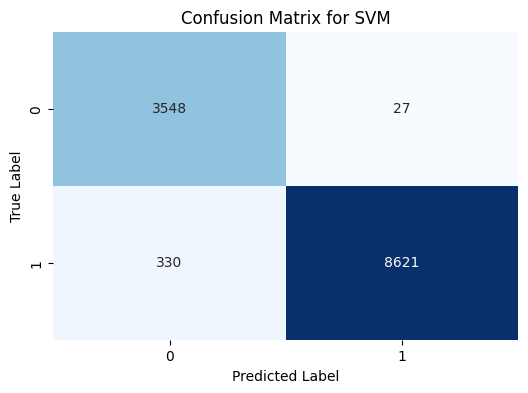

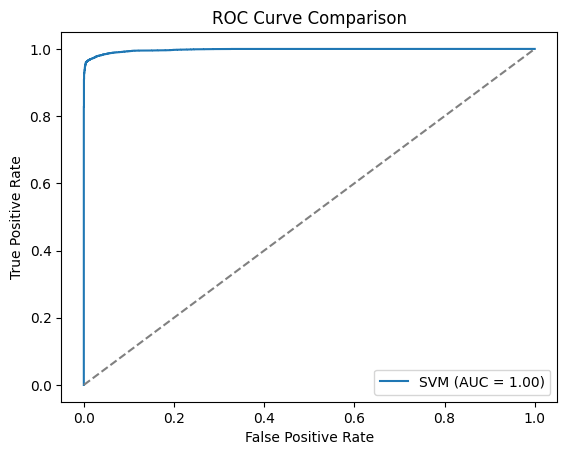

---------------------------------------------------------------------------
Evaluation for Naive Bayes:
Training Accuracy: 0.7625
Testing Accuracy: 0.8563
              precision    recall  f1-score   support

           0       0.89      0.56      0.69      3575
           1       0.85      0.97      0.91      8951

    accuracy                           0.86     12526
   macro avg       0.87      0.77      0.80     12526
weighted avg       0.86      0.86      0.85     12526

[[2017 1558]
 [ 242 8709]]


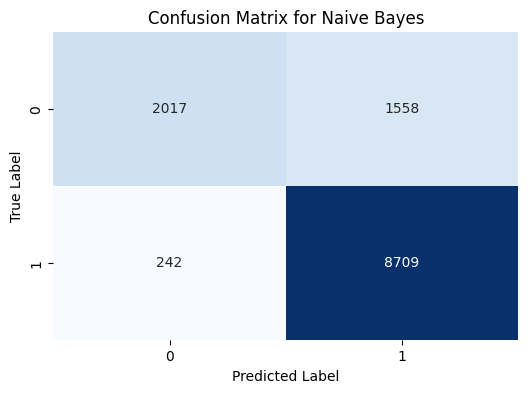

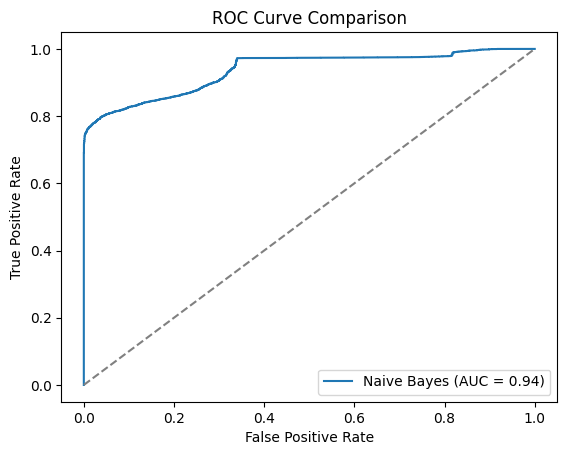

---------------------------------------------------------------------------


In [ ]:
#Create basic models with seleced features

# Define models
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'SVM': SVC(probability=True),
    'Naive Bayes': GaussianNB()
}

# Train and evaluate each model
for name, model in models.items():
    #Train the model
    model.fit(X_train_resampled, y_train_resampled)

    # Make predictions on training data
    y_train_pred = model.predict(X_train_resampled)

    # Make predictions on testing data
    y_test_pred = model.predict(X_test_scaled)

    # Calculate training and testing accuracy
    train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    print(f"Evaluation for {name}:")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Testing Accuracy: {test_accuracy:.4f}")
    print(classification_report(y_test, y_test_pred))
    print(confusion_matrix(y_test, y_test_pred))

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Compute ROC curve
    y_proba = model.predict_proba(X_test_scaled)[:, 1]  #this gets the probability estimates from prediction which is needed for ROC that uses probabilities
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Diagonal line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve Comparison")       #print ROC curve to get a visualization of AUC and performance
    plt.legend()
    plt.show()

    print("-" * 75)


Naive Bayes test accuracy has increased by about 10 percent. This is good but, the gap between the test accuracy and training accuracy is still about 10% in favor of test, which is still weird.

### MLP

In [ ]:
# Try MLP with feature selection

# Define the MLP model
mlp = Sequential()
mlp.add(Dense(64, input_dim=X_train_resampled.shape[1], activation='relu'))  # Resampled data
mlp.add(Dropout(0.3))
mlp.add(Dense(32, activation='relu'))
mlp.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile the model
mlp.compile(optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy'])

# Train the model
history = mlp.fit(X_train_resampled, y_train_resampled,
                  validation_split=0.2,
                  epochs=10,
                  batch_size=32,
                  verbose=1)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1788/1788 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9020 - loss: 0.2410 - val_accuracy: 0.9387 - val_loss: 0.1042
Epoch 2/10
1788/1788 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9703 - loss: 0.0768 - val_accuracy: 0.9630 - val_loss: 0.0751
Epoch 3/10
1788/1788 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9776 - loss: 0.0583 - val_accuracy: 0.9757 - val_loss: 0.0501
Epoch 4/10
1788/1788 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9828 - loss: 0.0436 - val_accuracy: 0.9829 - val_loss: 0.0425
Epoch 5/10
1788/1788 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9863 - loss: 0.0356 - val_accuracy: 0.9969 - val_loss: 0.0166
Epoch 6/10
1788/1788 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9870 - loss: 0.0324 - val_accuracy: 0.9934 - val_loss: 0.0249
Epoch 7/10
1788/1788 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9884 - loss: 0.0291 - val_accuracy: 0.9927 - val_loss: 0.0258
Epoch 8/10
1788/1788 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9901 - loss: 0.0258 - val_accurac

2235/2235 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
392/392 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Evaluation for MLP:
Training Accuracy: 0.9937
Testing Accuracy: 0.9943
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3575
           1       0.99      1.00      1.00      8951

    accuracy                           0.99     12526
   macro avg       0.99      0.99      0.99     12526
weighted avg       0.99      0.99      0.99     12526

[[3522   53]
 [  18 8933]]


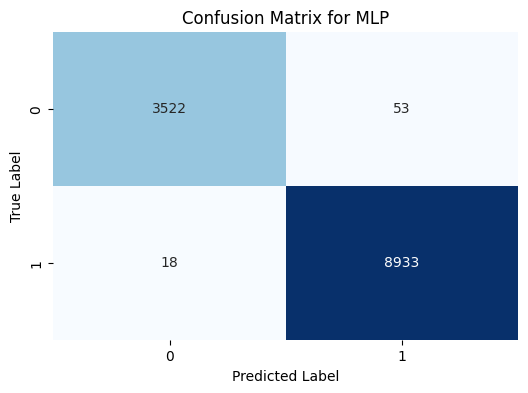

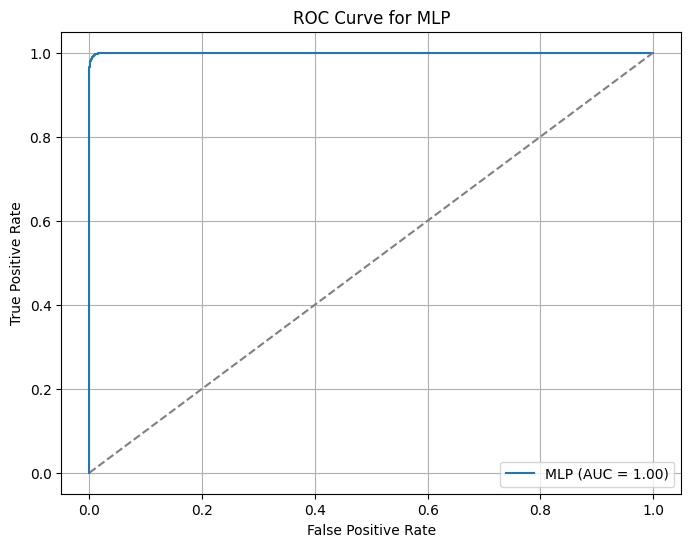

In [ ]:
# Predict on training and test sets
y_train_pred_prob = mlp.predict(X_train_resampled).ravel()
y_test_pred_prob = mlp.predict(X_test_scaled).ravel()

# Binarize the predictions
y_train_pred = (y_train_pred_prob >= 0.5).astype(int)
y_test_pred = (y_test_pred_prob >= 0.5).astype(int)

# Evaluation
train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Evaluation for MLP:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")
print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))

# Pretty Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for MLP')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'MLP (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for MLP')
plt.legend()
plt.grid()
plt.show()

Basically no change for MLP

### Random Forest

Evaluation for Random Forest:
Training Accuracy: 1.0000
Testing Accuracy: 0.9999
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3575
           1       1.00      1.00      1.00      8951

    accuracy                           1.00     12526
   macro avg       1.00      1.00      1.00     12526
weighted avg       1.00      1.00      1.00     12526

[[3575    0]
 [   1 8950]]


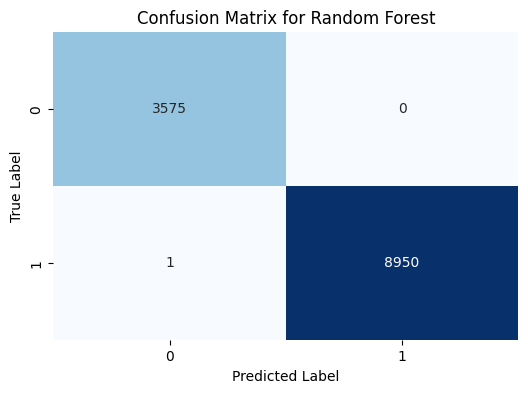

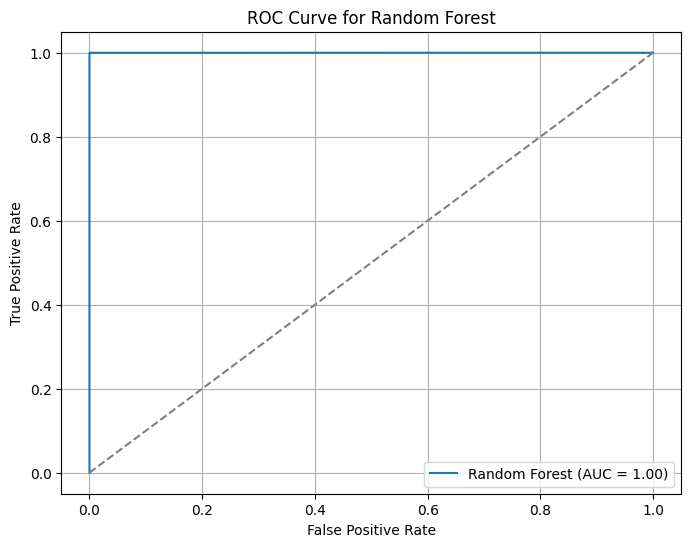

In [ ]:
# Try random forest with feature selection

# Initialize Random Forest
rf_model = RandomForestClassifier(n_estimators=50, random_state=42)

# Train the model
rf_model.fit(X_train_resampled, y_train_resampled)

# Predict on train and test sets
y_train_pred = rf_model.predict(X_train_resampled)
y_test_pred = rf_model.predict(X_test_scaled)
y_test_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

# Accuracy scores
train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print metrics
print("Evaluation for Random Forest:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")
print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))

# Pretty Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for Random Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest')
plt.legend()
plt.grid()
plt.show()


No change for random forest

## Addressing Feature Skewness

In [ ]:
# Feature Skewness

# Drop features based on correlation and low importance
features_to_drop = ['PM2.5', 'NC0.5', 'NC1.0', 'NC2.5', 'eCO2[ppm]', 'UTC', 'Hour', 'Day']
target_col = 'Fire Alarm'

# Drop selected features
X = df.drop(columns=features_to_drop + [target_col])
y = df[target_col]

# Stratified Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Compute skewness before transformation
skew_before = X_train.skew()

# Use QuantileTransformer to address skewness
transformer = QuantileTransformer(output_distribution='normal', random_state=42)

# Features to transform (all features except 'Temperature[C]' / skewness >1 or <-1)
features_to_transform = ['Humidity[%]', 'TVOC[ppb]', 'Raw H2', 'Raw Ethanol', 'Pressure[hPa]', 'PM1.0']

# Transform the features with high skewness
X_train_transformed = X_train.copy()
X_test_transformed = X_test.copy()
X_train_transformed[features_to_transform] = transformer.fit_transform(X_train[features_to_transform])
X_test_transformed[features_to_transform] = transformer.transform(X_test[features_to_transform])

# Compute skewness after transformation
skew_after = X_train_transformed.skew()

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_transformed)
X_test_scaled = scaler.transform(X_test_transformed)

# SMOTE-ENN for balancing
smote_enn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train_scaled, y_train)

# Skewness check
print("Skewness before:")
print(skew_before)
print()
print("Skewness after:")
print(skew_after)

Skewness before:
Temperature[C]    -0.625505
Humidity[%]       -2.471175
TVOC[ppb]          6.826733
Raw H2            -2.907800
Raw Ethanol       -1.677576
Pressure[hPa]     -3.615101
PM1.0             10.730640
dtype: float64

Skewness after:
Temperature[C]   -0.625505
Humidity[%]       0.014588
TVOC[ppb]        -0.923259
Raw H2            0.050180
Raw Ethanol       0.018980
Pressure[hPa]     0.040487
PM1.0            -0.266508
dtype: float64


Quantile transformer was used to transform the data and fix the skew in features. Like in standard scaler, only the training is used to fit to prevent leakage. The quantile transformer works by ranking values by the quanitile and transforming them to create a more normal distribtuion but still maintaing the quantiles order / ranking (sort-wise).

### Logistic Regression, Decision Tree, SVM, Naive Bayes

Evaluation for Logistic Regression:
Training Accuracy: 0.8348
Testing Accuracy: 0.8434
              precision    recall  f1-score   support

           0       0.69      0.81      0.75      3575
           1       0.92      0.86      0.89      8951

    accuracy                           0.84     12526
   macro avg       0.81      0.83      0.82     12526
weighted avg       0.85      0.84      0.85     12526

[[2886  689]
 [1272 7679]]


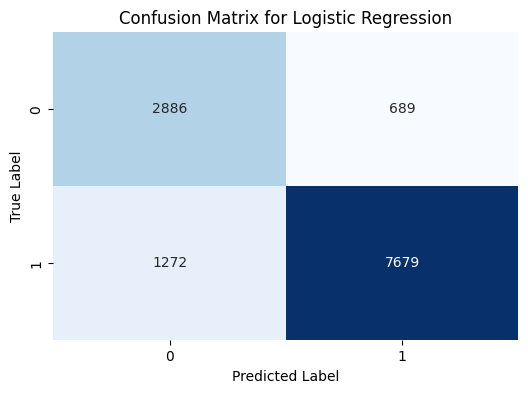

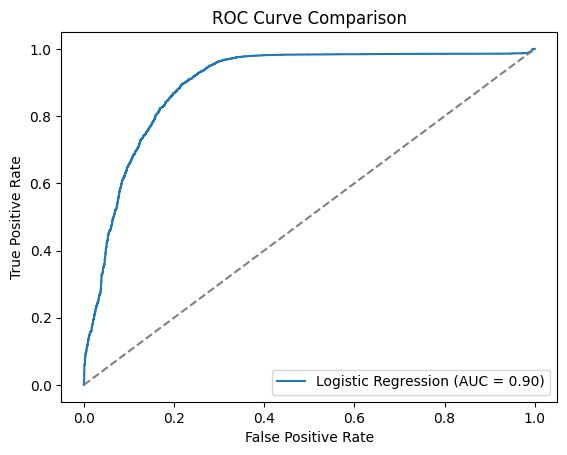

---------------------------------------------------------------------------
Evaluation for Decision Tree:
Training Accuracy: 1.0000
Testing Accuracy: 0.9992
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3575
           1       1.00      1.00      1.00      8951

    accuracy                           1.00     12526
   macro avg       1.00      1.00      1.00     12526
weighted avg       1.00      1.00      1.00     12526

[[3569    6]
 [   4 8947]]


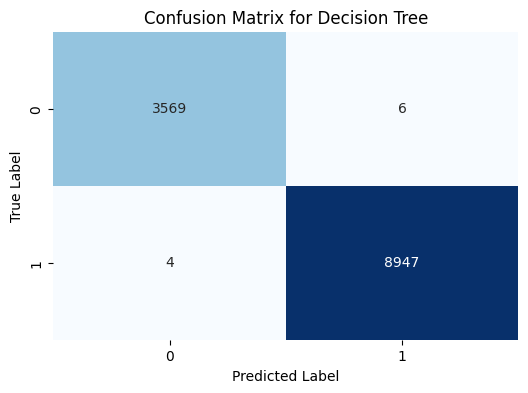

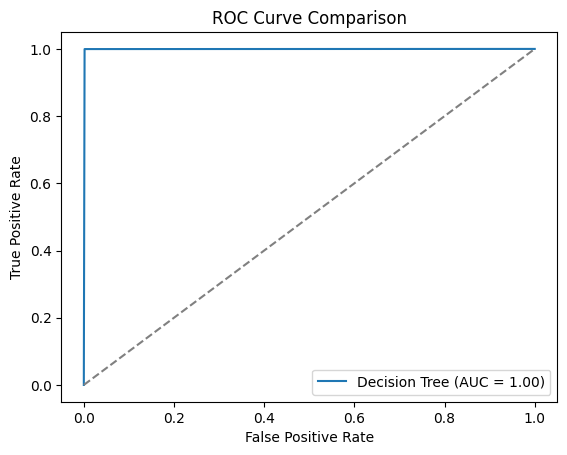

---------------------------------------------------------------------------
Evaluation for SVM:
Training Accuracy: 0.9996
Testing Accuracy: 0.9993
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3575
           1       1.00      1.00      1.00      8951

    accuracy                           1.00     12526
   macro avg       1.00      1.00      1.00     12526
weighted avg       1.00      1.00      1.00     12526

[[3573    2]
 [   7 8944]]


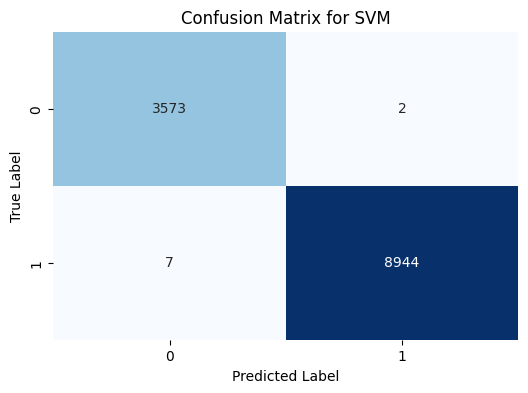

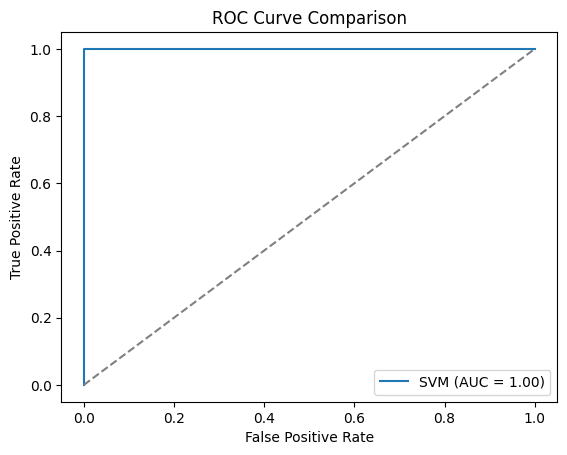

---------------------------------------------------------------------------
Evaluation for Naive Bayes:
Training Accuracy: 0.9056
Testing Accuracy: 0.9103
              precision    recall  f1-score   support

           0       0.82      0.88      0.85      3575
           1       0.95      0.92      0.94      8951

    accuracy                           0.91     12526
   macro avg       0.88      0.90      0.89     12526
weighted avg       0.91      0.91      0.91     12526

[[3156  419]
 [ 704 8247]]


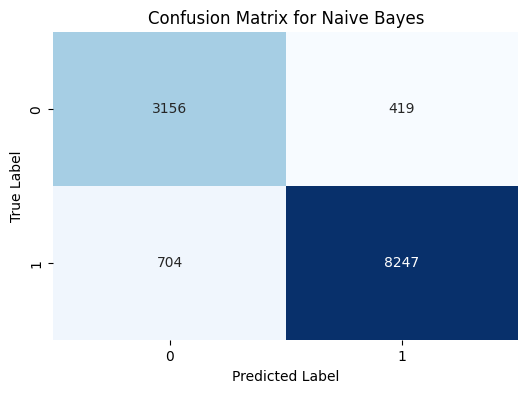

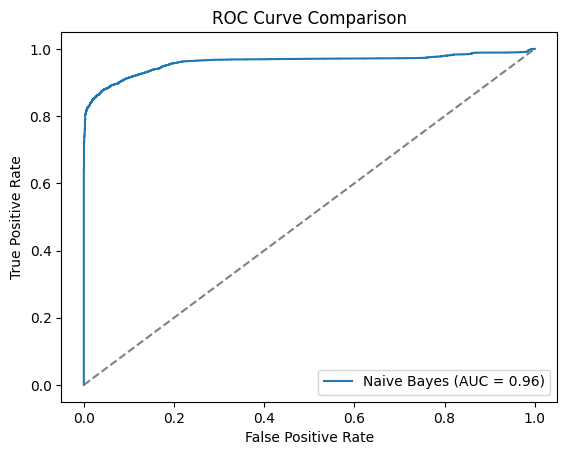

---------------------------------------------------------------------------


In [ ]:
#Train the basic models with the change in skew

# Define models
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'SVM': SVC(probability=True),
    'Naive Bayes': GaussianNB()
}

# Train and evaluate each model
for name, model in models.items():
    #Train the model
    model.fit(X_train_resampled, y_train_resampled)

    # Make predictions on training data
    y_train_pred = model.predict(X_train_resampled)

    # Make predictions on testing data
    y_test_pred = model.predict(X_test_scaled)

    # Calculate training and testing accuracy
    train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    print(f"Evaluation for {name}:")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Testing Accuracy: {test_accuracy:.4f}")
    print(classification_report(y_test, y_test_pred))
    print(confusion_matrix(y_test, y_test_pred))

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Compute ROC curve
    y_proba = model.predict_proba(X_test_scaled)[:, 1]  #this gets the probability estimates from prediction which is needed for ROC that uses probabilities
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Diagonal line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve Comparison")       #print ROC curve to get a visualization of AUC and performance
    plt.legend()
    plt.show()

    print("-" * 75)


Logistic Regression was affected negatively heavily by dropping about 5%. However, SVM increased by 2% reaching near perfect and Naive Bayes finally broke the 90% threshold by increasing 6%.

### MLP

In [ ]:
# Try MLP with addressed skewness

# Define the MLP model
mlp = Sequential()
mlp.add(Dense(64, input_dim=X_train_resampled.shape[1], activation='relu'))  # Resampled data
mlp.add(Dropout(0.3))
mlp.add(Dense(32, activation='relu'))
mlp.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile the model
mlp.compile(optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy'])

# Train the model
history = mlp.fit(X_train_resampled, y_train_resampled,
                  validation_split=0.2,
                  epochs=10,
                  batch_size=32,
                  verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1790/1790 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9109 - loss: 0.2179 - val_accuracy: 0.9903 - val_loss: 0.0299
Epoch 2/10
1790/1790 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9904 - loss: 0.0344 - val_accuracy: 0.9968 - val_loss: 0.0103
Epoch 3/10
1790/1790 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9953 - loss: 0.0170 - val_accuracy: 0.9983 - val_loss: 0.0058
Epoch 4/10
1790/1790 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9967 - loss: 0.0104 - val_accuracy: 0.9987 - val_loss: 0.0041
Epoch 5/10
1790/1790 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9979 - loss: 0.0081 - val_accuracy: 0.9993 - val_loss: 0.0022
Epoch 6/10
1790/1790 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9981 - loss: 0.0067 - val_accuracy: 0.9992 - val_loss: 0.0013
Epoch 7/10
1790/1790 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9982 - loss: 0.0059 - val_accuracy: 0.9992 - val_loss: 0.0013
Epoch 8/10
1790/1790 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9989 - loss: 0.00

2237/2237 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Evaluation for MLP:
Training Accuracy: 0.9996
Testing Accuracy: 0.9991
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3575
           1       1.00      1.00      1.00      8951

    accuracy                           1.00     12526
   macro avg       1.00      1.00      1.00     12526
weighted avg       1.00      1.00      1.00     12526

[[3572    3]
 [   8 8943]]


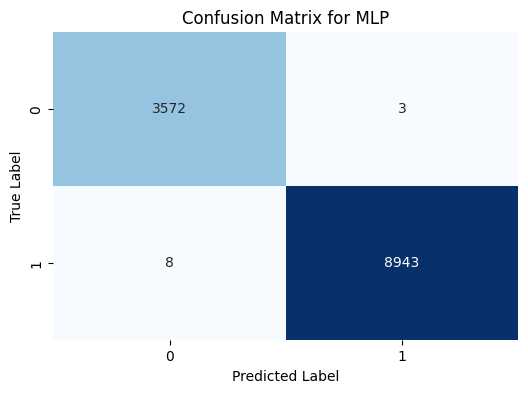

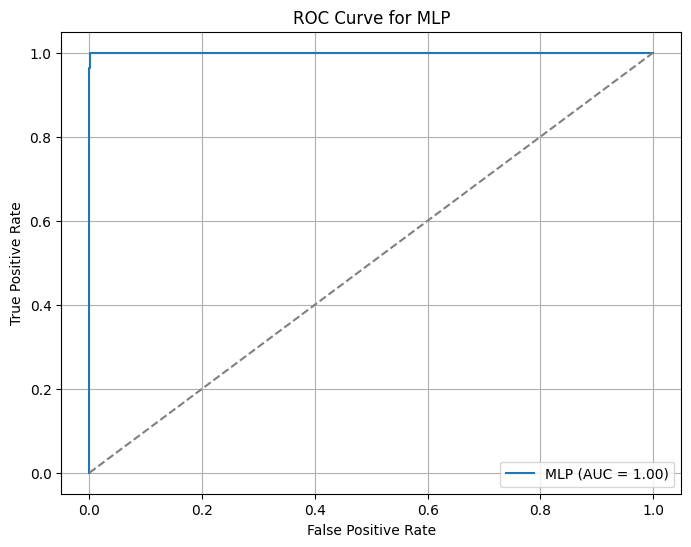

In [ ]:
# Predict on training and test sets
y_train_pred_prob = mlp.predict(X_train_resampled).ravel()
y_test_pred_prob = mlp.predict(X_test_scaled).ravel()

# Binarize the predictions
y_train_pred = (y_train_pred_prob >= 0.5).astype(int)
y_test_pred = (y_test_pred_prob >= 0.5).astype(int)

# Evaluation
train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Evaluation for MLP:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")
print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))

# Pretty Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for MLP')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'MLP (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for MLP')
plt.legend()
plt.grid()
plt.show()

The number of false positive and false negatives went down a lot

### Random Forest

Evaluation for Random Forest:
Training Accuracy: 1.0000
Testing Accuracy: 0.9998
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3575
           1       1.00      1.00      1.00      8951

    accuracy                           1.00     12526
   macro avg       1.00      1.00      1.00     12526
weighted avg       1.00      1.00      1.00     12526

[[3574    1]
 [   1 8950]]


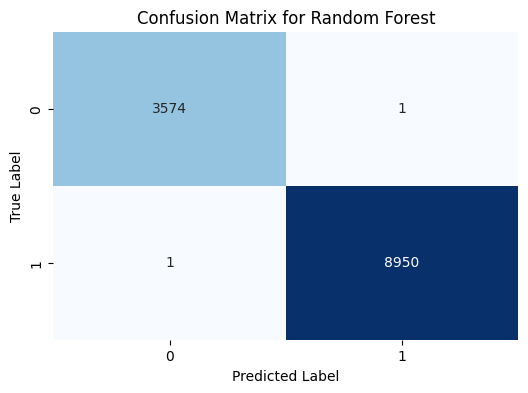

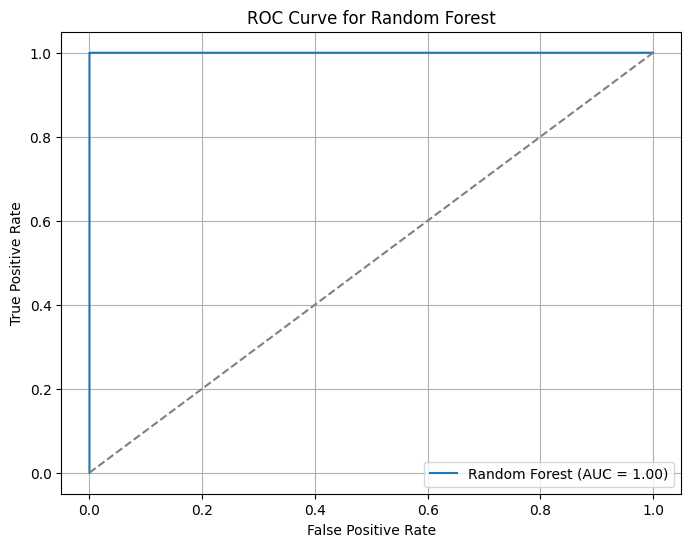

In [ ]:
# Try random forest with addressed skewness

# Initialize Random Forest
rf_model = RandomForestClassifier(n_estimators=50, random_state=42)

# Train the model
rf_model.fit(X_train_resampled, y_train_resampled)

# Predict on train and test sets
y_train_pred = rf_model.predict(X_train_resampled)
y_test_pred = rf_model.predict(X_test_scaled)
y_test_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

# Accuracy scores
train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print metrics
print("Evaluation for Random Forest:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")
print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))

# Pretty Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for Random Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest')
plt.legend()
plt.grid()
plt.show()


Random forest obtained one more false positive.

## Tune Hyperparameters

### Logistic Regression

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters: {'C': 0.01, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Evaluation for Logistic Regression:
Training Accuracy: 0.8349
Testing Accuracy: 0.8433
              precision    recall  f1-score   support

           0       0.69      0.81      0.75      3575
           1       0.92      0.86      0.89      8951

    accuracy                           0.84     12526
   macro avg       0.81      0.83      0.82     12526
weighted avg       0.85      0.84      0.85     12526

[[2884  691]
 [1272 7679]]


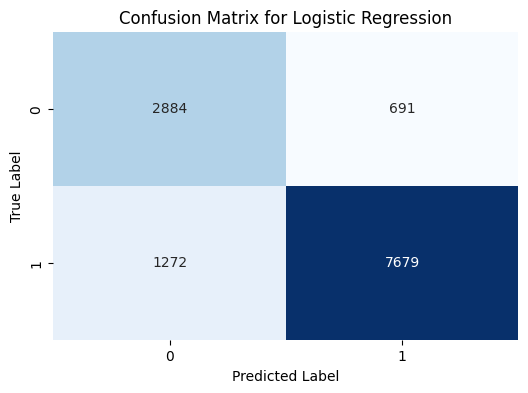

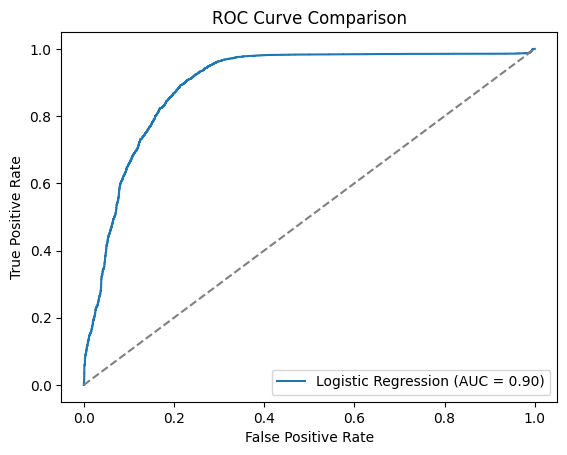

In [ ]:
# Hypertune parameters for logistic regression

# Define parameter grid for Logistic Regression
param_grid_lr = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear'],  # 'liblinear' supports both l1 and l2 penalties
    'max_iter': [100, 500, 1000]
}

# Initialize Logistic Regression
lr = LogisticRegression()
name = "Logistic Regression"

# Set up GridSearchCV
grid_lr = GridSearchCV(
    lr,
    param_grid=param_grid_lr,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit to the resampled training data
grid_lr.fit(X_train_resampled, y_train_resampled)

# Print best parameters
print("Best Parameters:", grid_lr.best_params_)

# Make predictions on training data
y_train_pred = grid_lr.predict(X_train_resampled)

# Make predictions on testing data
y_test_pred = grid_lr.predict(X_test_scaled)

# Calculate training and testing accuracy
train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Evaluation for {name}:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")
print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix for {name}')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Compute ROC curve
y_proba = grid_lr.predict_proba(X_test_scaled)[:, 1]  #this gets the probability estimates from prediction which is needed for ROC that uses probabilities
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")       #print ROC curve to get a visualization of AUC and performance
plt.legend()
plt.show()

Tuning did bascially nothing for logistic regression. It was tuned on penalty, C, solver and max iterations.

### Decision Tree


Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Evaluation for Decision Tree:
Training Accuracy: 1.0000
Testing Accuracy: 0.9998
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3575
           1       1.00      1.00      1.00      8951

    accuracy                           1.00     12526
   macro avg       1.00      1.00      1.00     12526
weighted avg       1.00      1.00      1.00     12526

[[3574    1]
 [   1 8950]]


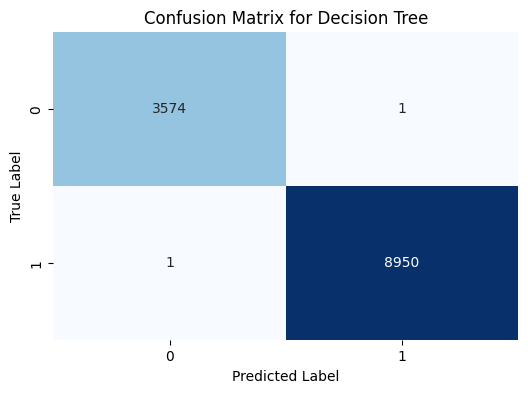

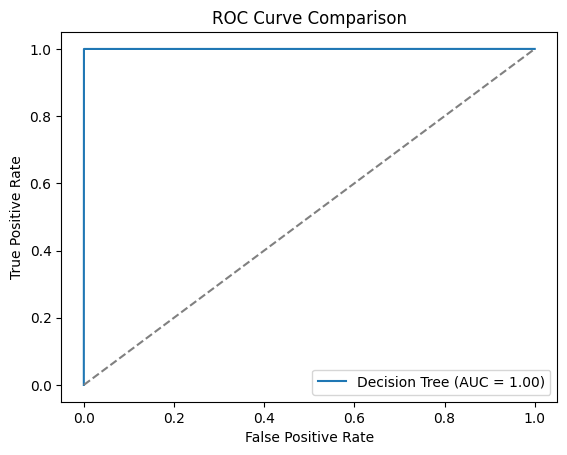

In [ ]:
# Hypertune parameters for Decision Tree

# Define parameter grid for Decision Tree
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Decision Tree
dt = DecisionTreeClassifier(random_state=42)
name = "Decision Tree"

# Set up GridSearchCV
grid_dt = GridSearchCV(
    dt,
    param_grid=param_grid_dt,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit to the resampled training data
grid_dt.fit(X_train_resampled, y_train_resampled)

# Print best parameters
print("Best Parameters:", grid_dt.best_params_)

# Make predictions on training data
y_train_pred = grid_dt.predict(X_train_resampled)

# Make predictions on testing data
y_test_pred = grid_dt.predict(X_test_scaled)

# Calculate training and testing accuracy
train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Evaluation for {name}:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")
print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix for {name}')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Compute ROC curve
y_proba = grid_dt.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


Improved decision tree slightly, though it was already near perfect. It was tuned on criterion, max depth, min samples for each split and min samples for each leaf.

### SVM

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Evaluation for Support Vector Machine:
Training Accuracy: 1.0000
Testing Accuracy: 0.9998
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3575
           1       1.00      1.00      1.00      8951

    accuracy                           1.00     12526
   macro avg       1.00      1.00      1.00     12526
weighted avg       1.00      1.00      1.00     12526

[[3574    1]
 [   2 8949]]


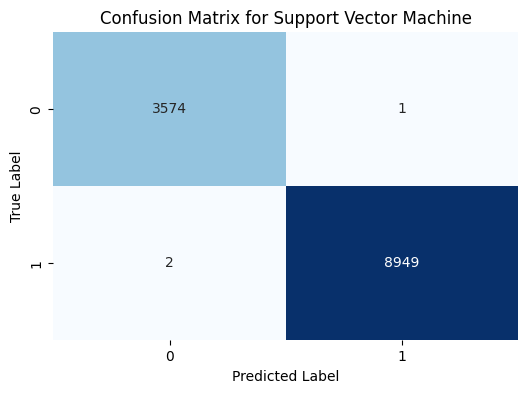

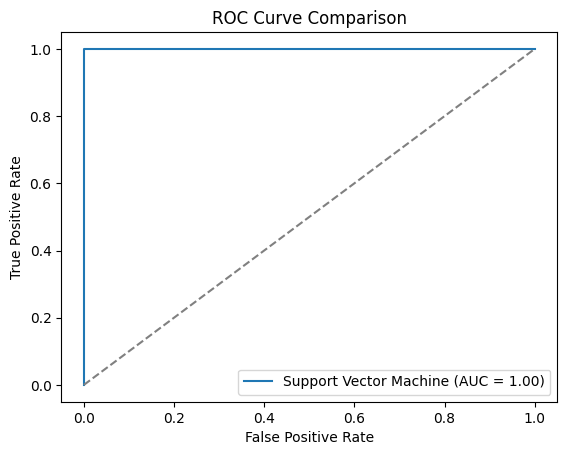

In [ ]:
# Hypertune parameters for SVM

# Sample 20% of the resampled training data for faster tuning
X_sampled, _, y_sampled, _ = train_test_split(
    X_train_resampled, y_train_resampled, test_size=0.8, random_state=42, stratify=y_train_resampled
)

# Define parameter grid for SVM
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto'],
}

# Initialize SVM without probability to speed up tuning
svm = SVC(probability=False, random_state=42)
name = "Support Vector Machine"

# Set up GridSearchCV
grid_svm = GridSearchCV(
    svm,
    param_grid=param_grid_svm,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit to the 20% sampled training data
grid_svm.fit(X_sampled, y_sampled)

# Print best parameters
print("Best Parameters:", grid_svm.best_params_)

# Retrain final SVM with proba for ROC
best_params = grid_svm.best_params_
final_svm = SVC(**best_params, probability=True, random_state=42)
final_svm.fit(X_train_resampled, y_train_resampled)

# Make predictions on training data
y_train_pred = final_svm.predict(X_train_resampled)

# Make predictions on testing data
y_test_pred = final_svm.predict(X_test_scaled)

# Calculate training and testing accuracy
train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Evaluation for {name}:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")
print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix for {name}')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Compute ROC curve
y_proba = final_svm.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


Tuning did not change much besides fixed a few false negatives. It was tuned on C, kernel and gamma. Unlike the others, since SVM takes so long, it had to be tuned on only 20% of the data.

## Naive Bayes

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best Parameters: {'var_smoothing': np.float64(1e-09)}
Evaluation for Naive Bayes:
Training Accuracy: 0.9056
Testing Accuracy: 0.9103
              precision    recall  f1-score   support

           0       0.82      0.88      0.85      3575
           1       0.95      0.92      0.94      8951

    accuracy                           0.91     12526
   macro avg       0.88      0.90      0.89     12526
weighted avg       0.91      0.91      0.91     12526

[[3156  419]
 [ 704 8247]]


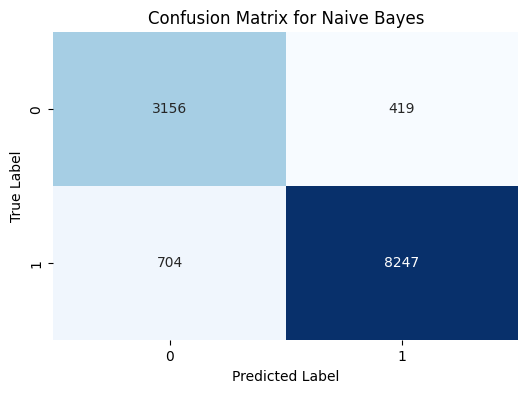

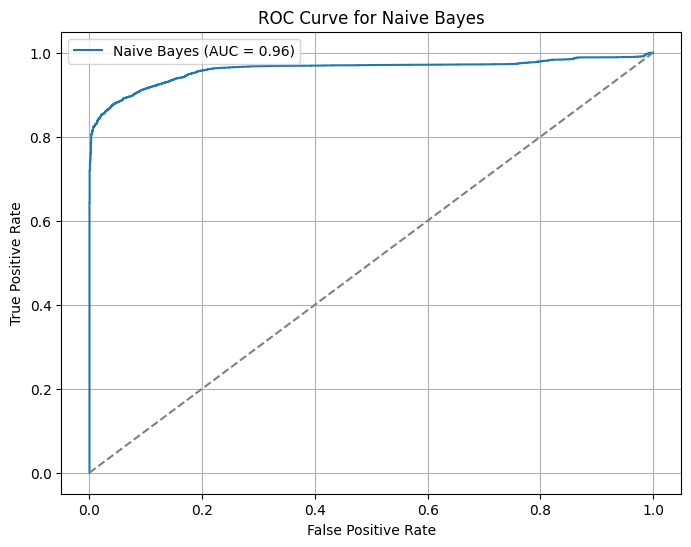

In [ ]:
# Define parameter grid for Naive Bayes
param_grid_nb = {
    'var_smoothing': np.logspace(-9, -3, 7)
}

# Initialize Naive Bayes
nb = GaussianNB()
name = "Naive Bayes"

# Set up GridSearchCV
grid_nb = GridSearchCV(
    nb,
    param_grid=param_grid_nb,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit to the resampled training data
grid_nb.fit(X_train_resampled, y_train_resampled)

# Print best parameters
print("Best Parameters:", grid_nb.best_params_)

# Predict on train and test sets
y_train_pred = grid_nb.predict(X_train_resampled)
y_test_pred = grid_nb.predict(X_test_scaled)
y_test_proba = grid_nb.predict_proba(X_test_scaled)[:, 1]

# Accuracy scores
train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print evaluation
print(f"Evaluation for {name}:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")
print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))

# Pretty Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix for {name}')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {name}')
plt.legend()
plt.grid()
plt.show()

Naive Bayes does not have many hyperparameters so the only thing tuned was the var smoothing which did not have much effect.

### MLP

Trial 10 Complete [00h 00m 55s]
val_accuracy: 0.9994411468505859

Best val_accuracy So Far: 0.9996008276939392
Total elapsed time: 00h 04m 59s
Best Hyperparameters: {'neurons': 128, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'tuner/epochs': 5, 'tuner/initial_epoch': 2, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0003'}
2237/2237 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Evaluation for MLP:
Training Accuracy: 0.9996
Testing Accuracy: 0.9996
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3575
           1       1.00      1.00      1.00      8951

    accuracy                           1.00     12526
   macro avg       1.00      1.00      1.00     12526
weighted avg       1.00      1.00      1.00     12526

[[3572    3]
 [   2 8949]]


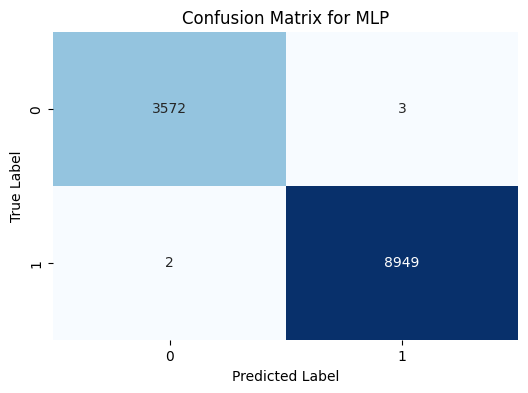

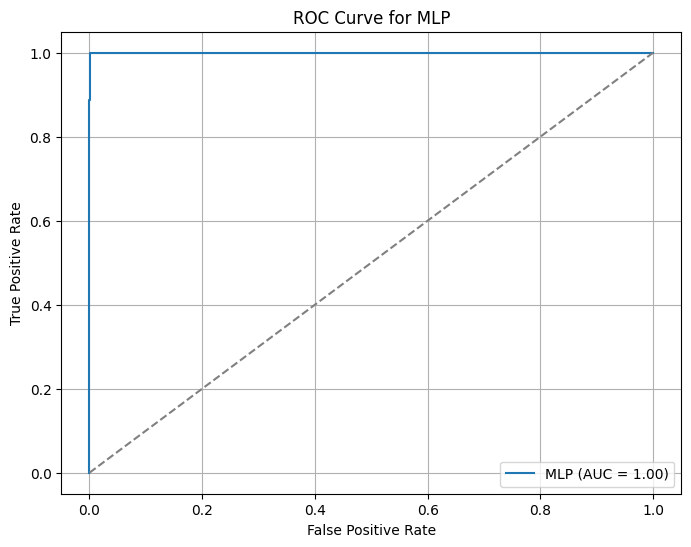

In [ ]:
# Tune MLP

# Define the model-building function with Keras Tuner hyperparameters
def build_mlp_model(hp):
    model = Sequential()
    model.add(Dense(
        units=hp.Int('neurons', min_value=32, max_value=128, step=32),
        input_dim=X_train_resampled.shape[1],
        activation='relu')
    )
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[0.001, 0.01])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Set up Keras Tuner with Hyperband
tuner = kt.Hyperband(
    build_mlp_model,
    objective='val_accuracy',  # Can use 'val_loss', 'val_accuracy', etc.
    max_epochs=5,
    factor=3,
    directory='my_dir',  # Specify the directory to save the results
    project_name='mlp_tuning'
)

# Perform hyperparameter tuning
tuner.search(X_train_resampled, y_train_resampled, validation_data=(X_test_scaled, y_test), epochs=10, batch_size=32)

# Get the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hp = tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters

print("Best Hyperparameters:", best_hp.values)

# Evaluate the best model on the test set
y_train_pred_prob = best_model.predict(X_train_resampled)
y_test_pred_prob = best_model.predict(X_test_scaled)

y_train_pred = (y_train_pred_prob >= 0.5).astype(int)
y_test_pred = (y_test_pred_prob >= 0.5).astype(int)

# Evaluation
train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Evaluation for MLP:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")
print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))

# Confusion Matrix Plot
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for MLP')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'MLP (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for MLP')
plt.legend()
plt.grid()
plt.show()


Not much change for MLP. It was tuned on neurons, dropout rate and learning rate. Unlike the others, this one had to be done with keras tuner instead of grid search.

### Random Forest

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Evaluation for Random Forest:
Training Accuracy: 1.0000
Testing Accuracy: 0.9998
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3575
           1       1.00      1.00      1.00      8951

    accuracy                           1.00     12526
   macro avg       1.00      1.00      1.00     12526
weighted avg       1.00      1.00      1.00     12526

[[3574    1]
 [   1 8950]]


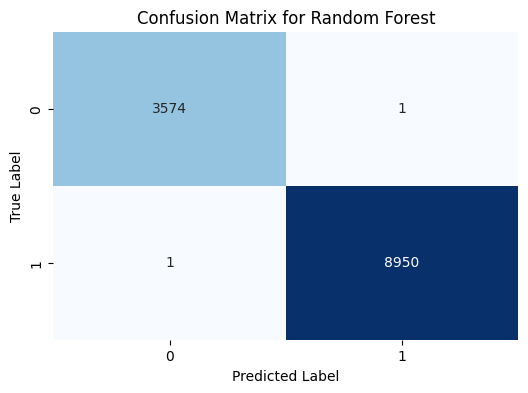

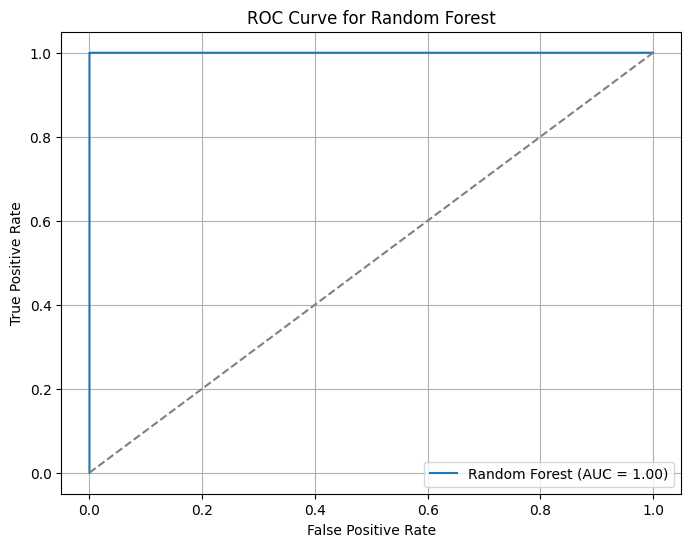

In [ ]:
# Define parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Initialize base model
rf = RandomForestClassifier(random_state=42)

# GridSearchCV setup
grid_rf = GridSearchCV(estimator=rf,
                       param_grid=param_grid_rf,
                       scoring='f1',
                       cv=5,
                       verbose=1,
                       n_jobs=-1)

# Fit to training data
grid_rf.fit(X_train_resampled, y_train_resampled)

# Best parameters
print("Best Parameters:", grid_rf.best_params_)

# Predict
y_train_pred = rf_model.predict(X_train_resampled)
y_test_pred = rf_model.predict(X_test_scaled)
y_test_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

# Accuracy
train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Evaluation
print("Evaluation for Random Forest:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")
print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))

# Confusion Matrix Plot
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for Random Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest')
plt.legend()
plt.grid()
plt.show()

Tuning had no change at all for random forest.

## Model Fusion

Evaluation for Model Fusion (Weighted Average):
Testing Accuracy: 0.9998
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3575
           1       1.00      1.00      1.00      8951

    accuracy                           1.00     12526
   macro avg       1.00      1.00      1.00     12526
weighted avg       1.00      1.00      1.00     12526

[[3574    1]
 [   2 8949]]


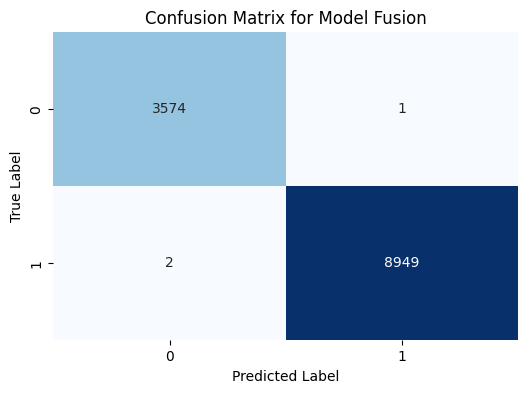

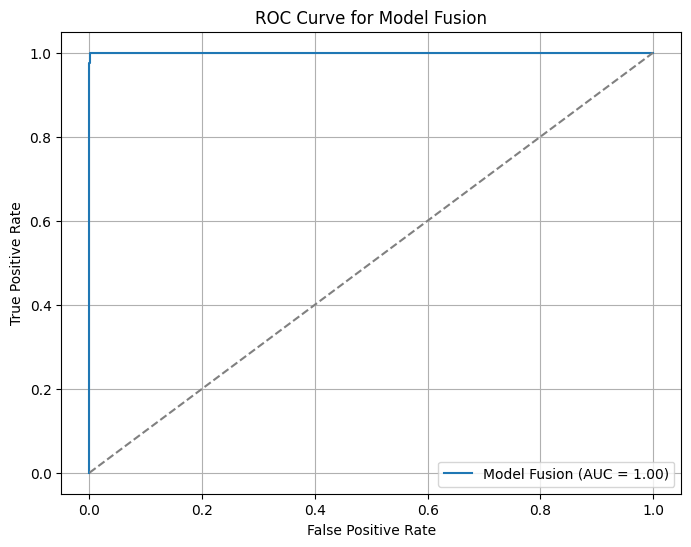

In [ ]:
# Get probability predictions from each model
proba_lr = grid_lr.predict_proba(X_test_scaled)[:, 1]
proba_dt = grid_dt.predict_proba(X_test_scaled)[:, 1]
proba_svm = final_svm.predict_proba(X_test_scaled)[:, 1]
proba_nb = grid_nb.predict_proba(X_test_scaled)[:, 1]

# Compute F1-scores on validation predictions to use as weights
f1_lr = f1_score(y_test, grid_lr.predict(X_test_scaled))
f1_dt = f1_score(y_test, grid_dt.predict(X_test_scaled))
f1_svm = f1_score(y_test, final_svm.predict(X_test_scaled))
f1_nb = f1_score(y_test, grid_nb.predict(X_test_scaled))

# Normalize weights so they sum to 1
f1_total = f1_lr + f1_dt + f1_svm + f1_nb
w_lr = f1_lr / f1_total
w_dt = f1_dt / f1_total
w_svm = f1_svm / f1_total
w_nb = f1_nb / f1_total

# Weighted average of probabilities
fused_proba = (
    w_lr * proba_lr +
    w_dt * proba_dt +
    w_svm * proba_svm +
    w_nb * proba_nb
)

# Final binary prediction
fused_pred = (fused_proba >= 0.5).astype(int)

# Evaluation
fused_accuracy = accuracy_score(y_test, fused_pred)
print("Evaluation for Model Fusion (Weighted Average):")
print(f"Testing Accuracy: {fused_accuracy:.4f}")
print(classification_report(y_test, fused_pred))
print(confusion_matrix(y_test, fused_pred))

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, fused_pred), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for Model Fusion')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, fused_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Model Fusion (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Model Fusion')
plt.legend()
plt.grid()
plt.show()


The fused model of Logistic Regression, Decision Tree, SVM and Naive Bayes does still not match up to random forest. It is one false negative worse.